In [120]:
import re
import unicodedata
from pathlib import Path
import numpy as np
import pandas as pd
# Auto-reload modules before executing code
%load_ext autoreload
%autoreload 2
from IPython.display import Image, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export PROJ_ROOT=~/Documents/TESI/FOLDER_CINECA/clinica
import os
os.environ["PROJ_ROOT"] = "/home/zano/Documents/TESI/FOLDER_CINECA/"
PROJ_ROOT = os.getenv("PROJ_ROOT")
print(PROJ_ROOT)
IMAGES_SAVE_PATH = os.path.join(PROJ_ROOT, "images")
print(IMAGES_SAVE_PATH)

/home/zano/Documents/TESI/FOLDER_CINECA/
/home/zano/Documents/TESI/FOLDER_CINECA/images


In [ ]:

import pandas as pd
from pathlib import Path

CSV_PATH = Path("minimal.csv")
NA_VALUES = ["", " ", "na","Nan", "Na", "NA", "n/a", "N/A", "\xa0"]
CLASSES_ORDER = ['MSA-P', 'MSA-C', 'PD']

df_raw = pd.read_csv(
    CSV_PATH,
    sep=",",
    encoding="utf-8",
    na_values=NA_VALUES,
    usecols=lambda col: col.strip() != "",  # drop the exported index column
)

# Drop the first column, which only contains indices from the export
df_raw = df_raw.iloc[:, 1:]
df_raw.head()

CODICE Sesso Data di nascita Diagnosi DI INVIO Diagnosi DEFINITA  \
0  5435.0     F      15/04/1950             MSA-P            MSA-P    
1  5717.0     M      25/02/1973             MSA-P            MSA-P    
2  5745.0     F      15/08/1959             MSA-P            MSA-P    
3  5753.0     F      09/04/1958           MSA-P/C            MSA-P    
4  5767.0     F      16/09/1960             MSA-P            MSA-P    

  ANNOTAZIONI SU DIAGNOSI FINALE  ANNO DIAGNOSI  ANNO ESORDIO SINTOMI MOTORI  \
0                            NaN         2022.0                       2020.0   
1                            NaN         2022.0                       2020.0   
2                            NaN         2022.0                       2021.0   
3                            NaN         2022.0                       2019.0   
4                           prob         2022.0                       2019.0   

   ANNO ESORDIO SINTOMI NON MOTORI  ANNO ESORDIO DISAUTONOMIA  ...  \
0                           2020.0                     2020.0  ...   
1                           2019.0                     2019.0  ...   
2                           2021.0                        NaN  ...   
3                           2019.0                     2019.0  ...   
4                           2021.0                     2022.0  ...   

  Cognitive decline  Normal RMN  Atrofia del putamen  \
0               0.0           0                  0.0   
1               0.0           0                  0.0   
2               0.0           0                  1.0   
3               0.0           0                  1.0   
4               0.0           1                  0.0   

   Atrofia peduncoli cerebellari medi  Atrofia ponte  Atrofia cervelletto  \
0                                 0.0            0.0                  1.0   
1                                 0.0            0.0                  0.0   
2                                 0.0            0.0                  0.0   
3                                 0.0            0.0                  0.0   
4                                 0.0            0.0                  0.0   

   Hot cross bun sign  Iperintensità putamen  \
0                 0.0                    0.0   
1                 0.0                    1.0   
2                 0.0                    1.0   
3                 0.0                    1.0   
4                 0.0                    0.0   

   Iperintensità peduncoli cerebellari medi  Caduta segnale putamen  
0                                       0.0                     1.0  
1                                       0.0                     0.0  
2                                       0.0                     1.0  
3                                       0.0                     1.0  
4                                       0.0                     0.0  

[5 rows x 71 columns]

## Normalize and sluggify code

In [58]:
df_raw.columns

Index(['CODICE', 'Sesso', 'Data di nascita', 'Diagnosi DI INVIO',
       'Diagnosi DEFINITA', 'ANNOTAZIONI SU DIAGNOSI FINALE', 'ANNO DIAGNOSI',
       'ANNO ESORDIO SINTOMI MOTORI', 'ANNO ESORDIO SINTOMI NON MOTORI',
       'ANNO ESORDIO DISAUTONOMIA', 'Età esordio', 'Durata malattia',
       'ANNI L-DOPA', 'ANNI DOPAMINOAAGONISTI', 'LEDD', 'UPDRS ON',
       'UPDRS OFF', 'Delta OFF ON', 'H & Y', 'deambulaz autonoma',
       'deambulaz appoggio', 'carrozzina', 'Cadute', 'Compass Totale',
       'Compass-OH', 'Compass-Vasc', 'Compass-Sudor', 'Compass-GI',
       'Compass-Uin', 'Compass-Pupil', 'Parkinsonism',
       'Poor L-Dopa responsivenes', 'Cerebellar syndrome',
       'Rapid progression w 3 yrs',
       'Moderate to severe postural instability w 3 yrs of motor onset',
       'Craniocervical dyst induced dy L-Dopa',
       'Severe speech impairement w 3 yrs', 'Severe dysphagia w 3 yrs',
       'Unexplained Babinski', 'Jerky myoclonic postural or kinetic tremor',
       'Postural d

In [59]:
def normalize_label(label: str) -> str:
    """
    Normalize column names for consistent, ASCII-only, and analysis-friendly processing.

    Steps performed:
    - Unicode normalization (NFKD form) to separate accents from base characters,
      then drop all non-ASCII (e.g., "è" → "e").
    - Collapse multiple whitespaces into single spaces and strip leading/trailing spaces.
    - Replace "&" with "and" for better compatibility in code or downstream ML.

    Parameters
    ----------
    label : str
        The original column name as extracted from a raw clinical spreadsheet.

    Returns
    -------
    str
        Cleaned, ASCII-only label with consistent whitespace and symbol handling.

    Examples
    --------
    >>> normalize_label("Anni d'età ")
    "Anni d'eta"
    >>> normalize_label("UPDRS & score generale")
    "UPDRS and score generale"
    """
    label = unicodedata.normalize("NFKD", label)
    label = label.encode("ascii", "ignore").decode("ascii")
    label = re.sub(r"\s+", " ", label.strip())
    label = label.replace("&", "and")
    return label

def slugify(label: str) -> str:
    """
    Convert a normalized label into a safe, Pythonic alias (slug).

    Steps performed:
    - Lowercase conversion.
    - Replace any sequence of non-alphanumeric characters with underscores.
    - Remove leading/trailing underscores.

    Parameters
    ----------
    label : str
        Input string (normalized clinical column name).

    Returns
    -------
    str
        Machine-friendly column alias suitable for use as a Pandas DataFrame column,
        YAML key, or Python variable.

    Examples
    --------
    >>> slugify("Anni d'eta")
    'anni_d_eta'
    >>> slugify("UPDRS and score generale")
    'updrs_and_score_generale'
    """
    return re.sub(r"[^0-9a-zA-Z]+", "_", label.lower()).strip("_")

original_columns = df_raw.columns
normalized_labels = [normalize_label(col) for col in original_columns]
#dictionary to map the original columns to the new ones
column_alias = {orig:slugify(norm) for orig, norm in zip (original_columns, normalized_labels)}

df = df_raw.rename(columns=column_alias)
df

codice sesso data_di_nascita diagnosi_di_invio diagnosi_definita  \
0   5435.0     F      15/04/1950             MSA-P            MSA-P    
1   5717.0     M      25/02/1973             MSA-P            MSA-P    
2   5745.0     F      15/08/1959             MSA-P            MSA-P    
3   5753.0     F      09/04/1958           MSA-P/C            MSA-P    
4   5767.0     F      16/09/1960             MSA-P            MSA-P    
..     ...   ...             ...               ...               ...   
85  7461.0     M      04/01/1959                PD                PD   
86  7544.0     M      19/08/1977                PD                PD   
87  7781.0     F      23/10/1958                PD                PD   
88  7787.0     M      09/12/1966                PD                PD   
89  7811.0     M      15/03/1959                PD             MSA-P   

   annotazioni_su_diagnosi_finale  anno_diagnosi  anno_esordio_sintomi_motori  \
0                             NaN         2022.0                       2020.0   
1                             NaN         2022.0                       2020.0   
2                             NaN         2022.0                       2021.0   
3                             NaN         2022.0                       2019.0   
4                            prob         2022.0                       2019.0   
..                            ...            ...                          ...   
85                            NaN         2024.0                       2023.0   
86                            NaN         2024.0                       2024.0   
87                            NaN         2024.0                       2023.0   
88                            NaN         2024.0                       2021.0   
89                            NaN         2024.0                       2022.0   

    anno_esordio_sintomi_non_motori  anno_esordio_disautonomia  ...  \
0                            2020.0                     2020.0  ...   
1                            2019.0                     2019.0  ...   
2                            2021.0                        NaN  ...   
3                            2019.0                     2019.0  ...   
4                            2021.0                     2022.0  ...   
..                              ...                        ...  ...   
85                           2024.0                     2024.0  ...   
86                           2024.0                     2024.0  ...   
87                              NaN                        NaN  ...   
88                           2024.0                        NaN  ...   
89                           2022.0                     2022.0  ...   

   cognitive_decline  normal_rmn  atrofia_del_putamen  \
0                0.0           0                  0.0   
1                0.0           0                  0.0   
2                0.0           0                  1.0   
3                0.0           0                  1.0   
4                0.0           1                  0.0   
..               ...         ...                  ...   
85               0.0         NaN                  1.0   
86               0.0         NaN                  1.0   
87               0.0         NaN                  1.0   
88               0.0         NaN                  NaN   
89               0.0         NaN                  0.0   

    atrofia_peduncoli_cerebellari_medi  atrofia_ponte  atrofia_cervelletto  \
0                                  0.0            0.0                  1.0   
1                                  0.0            0.0                  0.0   
2                                  0.0            0.0                  0.0   
3                                  0.0            0.0                  0.0   
4                                  0.0            0.0                  0.0   
..                                 ...            ...                  ...   
85                                 0.0            0.0                  0.0   
86  

In [60]:
df.columns

Index(['codice', 'sesso', 'data_di_nascita', 'diagnosi_di_invio',
       'diagnosi_definita', 'annotazioni_su_diagnosi_finale', 'anno_diagnosi',
       'anno_esordio_sintomi_motori', 'anno_esordio_sintomi_non_motori',
       'anno_esordio_disautonomia', 'eta_esordio', 'durata_malattia',
       'anni_l_dopa', 'anni_dopaminoaagonisti', 'ledd', 'updrs_on',
       'updrs_off', 'delta_off_on', 'h_and_y', 'deambulaz_autonoma',
       'deambulaz_appoggio', 'carrozzina', 'cadute', 'compass_totale',
       'compass_oh', 'compass_vasc', 'compass_sudor', 'compass_gi',
       'compass_uin', 'compass_pupil', 'parkinsonism',
       'poor_l_dopa_responsivenes', 'cerebellar_syndrome',
       'rapid_progression_w_3_yrs',
       'moderate_to_severe_postural_instability_w_3_yrs_of_motor_onset',
       'craniocervical_dyst_induced_dy_l_dopa',
       'severe_speech_impairement_w_3_yrs', 'severe_dysphagia_w_3_yrs',
       'unexplained_babinski', 'jerky_myoclonic_postural_or_kinetic_tremor',
       'postural

In [61]:
numeric_patterns = r"(anno|eta|durata|ledd|updrs|delta|compass|score|totale|indice|years?|anni)"
numeric_cols = [col for col in df.columns if re.search(numeric_patterns, col)]
# print(numeric_cols)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# binary_cols = [col for col in df.columns if df[col].dropna().astype(str).isin({"0", "1"}).all()]
# if binary_cols:
#     df[binary_cols] = df[binary_cols].apply(pd.to_numeric, errors="coerce").astype("Int8").astype(pd.BooleanDtype())

df
# if "data_di_nascita" in df.columns:
#     df["data_di_nascita"] = pd.to_datetime(df["data_di_nascita"], dayfirst=True, errors="coerce")

codice sesso data_di_nascita diagnosi_di_invio diagnosi_definita  \
0   5435.0     F      15/04/1950             MSA-P            MSA-P    
1   5717.0     M      25/02/1973             MSA-P            MSA-P    
2   5745.0     F      15/08/1959             MSA-P            MSA-P    
3   5753.0     F      09/04/1958           MSA-P/C            MSA-P    
4   5767.0     F      16/09/1960             MSA-P            MSA-P    
..     ...   ...             ...               ...               ...   
85  7461.0     M      04/01/1959                PD                PD   
86  7544.0     M      19/08/1977                PD                PD   
87  7781.0     F      23/10/1958                PD                PD   
88  7787.0     M      09/12/1966                PD                PD   
89  7811.0     M      15/03/1959                PD             MSA-P   

    annotazioni_su_diagnosi_finale  anno_diagnosi  \
0                              NaN         2022.0   
1                              NaN         2022.0   
2                              NaN         2022.0   
3                              NaN         2022.0   
4                              NaN         2022.0   
..                             ...            ...   
85                             NaN         2024.0   
86                             NaN         2024.0   
87                             NaN         2024.0   
88                             NaN         2024.0   
89                             NaN         2024.0   

    anno_esordio_sintomi_motori  anno_esordio_sintomi_non_motori  \
0                        2020.0                           2020.0   
1                        2020.0                           2019.0   
2                        2021.0                           2021.0   
3                        2019.0                           2019.0   
4                        2019.0                           2021.0   
..                          ...                              ...   
85                       2023.0                           2024.0   
86                       2024.0                           2024.0   
87                       2023.0                              NaN   
88                       2021.0                           2024.0   
89                       2022.0                           2022.0   

    anno_esordio_disautonomia  ...  cognitive_decline  normal_rmn  \
0                      2020.0  ...                0.0           0   
1                      2019.0  ...                0.0           0   
2                         NaN  ...                0.0           0   
3                      2019.0  ...                0.0           0   
4                      2022.0  ...                0.0           1   
..                        ...  ...                ...         ...   
85                     2024.0  ...                0.0         NaN   
86                     2024.0  ...                0.0         NaN   
87                        NaN  ...                0.0         NaN   
88                        NaN  ...                0.0         NaN   
89                     2022.0  ...                0.0         NaN   

    atrofia_del_putamen  atrofia_peduncoli_cerebellari_medi  atrofia_ponte  \
0                   0.0                                 0.0            0.0   
1                   0.0                                 0.0            0.0   
2                   1.0                                 0.0            0.0   
3                   1.0                                 0.0            0.0   
4                   0.0                                 0.0            0.0   
..                  ...                                 ...            ...   
85                  1.0                                 0.0            0.0   
86                  1.0                                 0.0            0.0   
87                  1.0                                 0.0            0.0   
88                  NaN                                 NaN            NaN  

In [62]:
categorical_maps = {
    "diagnosi_di_invio": {"MSA-P ": "MSA-P", "MSA P": "MSA-P", "PD ": "PD"},
    "diagnosi_definita": {"MSA-P ": "MSA-P", "MSA-P/C": "MSA-P", "PD ": "PD"},
}
for col in ["diagnosi_di_invio", "diagnosi_definita"]:
    if col in df.columns:
        series = (
            df[col]
            .astype("string") #convert to string
            .str.strip() #strip whitespace
            .replace("", pd.NA) #replace empty strings with NA
        )
        series = series.str.upper() #convert to uppercase
        if col in categorical_maps:
            series = series.replace(categorical_maps[col]) 
        df[col] = series

if "codice" in df.columns:
    df["codice"] = df["codice"].astype("string").str.strip()
    duplicates = df[df["codice"].duplicated(keep=False)]["codice"].unique().tolist()
    if duplicates:
        print("⚠️ Duplicated CODICE values:", duplicates)
    df = df.set_index("codice")

df.info()
df.head()

⚠️ Duplicated CODICE values: [<NA>]
<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 5435.0 to 7811.0
Data columns (total 70 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   sesso                                                           88 non-null     object 
 1   data_di_nascita                                                 88 non-null     object 
 2   diagnosi_di_invio                                               88 non-null     string 
 3   diagnosi_definita                                               88 non-null     string 
 4   annotazioni_su_diagnosi_finale                                  0 non-null      float64
 5   anno_diagnosi                                                   88 non-null     float64
 6   anno_esordio_sintomi_motori                                     88 non-null     float64
 7   anno_esordio_si

sesso data_di_nascita diagnosi_di_invio diagnosi_definita  \
codice                                                             
5435.0     F      15/04/1950             MSA-P             MSA-P   
5717.0     M      25/02/1973             MSA-P             MSA-P   
5745.0     F      15/08/1959             MSA-P             MSA-P   
5753.0     F      09/04/1958           MSA-P/C             MSA-P   
5767.0     F      16/09/1960             MSA-P             MSA-P   

        annotazioni_su_diagnosi_finale  anno_diagnosi  \
codice                                                  
5435.0                             NaN         2022.0   
5717.0                             NaN         2022.0   
5745.0                             NaN         2022.0   
5753.0                             NaN         2022.0   
5767.0                             NaN         2022.0   

        anno_esordio_sintomi_motori  anno_esordio_sintomi_non_motori  \
codice                                                                 
5435.0                       2020.0                           2020.0   
5717.0                       2020.0                           2019.0   
5745.0                       2021.0                           2021.0   
5753.0                       2019.0                           2019.0   
5767.0                       2019.0                           2021.0   

        anno_esordio_disautonomia  eta_esordio  ...  cognitive_decline  \
codice                                          ...                      
5435.0                     2020.0         70.0  ...                0.0   
5717.0                     2019.0         46.0  ...                0.0   
5745.0                        NaN         62.0  ...                0.0   
5753.0                     2019.0         61.0  ...                0.0   
5767.0                     2022.0         59.0  ...                0.0   

        normal_rmn  atrofia_del_putamen  atrofia_peduncoli_cerebellari_medi  \
codice                                                                        
5435.0           0                  0.0                                 0.0   
5717.0           0                  0.0                                 0.0   
5745.0           0                  1.0                                 0.0   
5753.0           0                  1.0                                 0.0   
5767.0           1                  0.0                                 0.0   

        atrofia_ponte  atrofia_cervelletto  hot_cross_bun_sign  \
codice                                                           
5435.0            0.0                  1.0                 0.0   
5717.0            0.0                  0.0                 0.0   
5745.0            0.0                  0.0                 0.0   
5753.0            0.0                  0.0                 0.0   
5767.0            0.0                  0.0                 0.0   

        iperintensita_putamen  iperintensita_peduncoli_cerebellari_medi  \
codice                                                                    
5435.0                    0.0                                       0.0   
5717.0                    1.0                                       0.0   
5745.0                    1.0                                       0.0   
5753.0                    1.0                                       0.0   
5767.0                    0.0                                       0.0   

        caduta_segnale_putamen  
codice                          
5435.0                     1.0  
5717.0                     0.0  
5745.0                     1.0  
5753.0                     1.0  
5767.0                     0.0  

[5 rows x 70 columns]

aggiungiamo la data di nascita come dato

In [63]:
from datetime import date, datetime

# Get current year
current_year = 2025

# Convert 'Data di nascita' to datetime and extract year
df['anno_nascita'] = pd.to_datetime(df['data_di_nascita'], format='%d/%m/%Y', errors='coerce').dt.year

# Calculate current age
df['eta_attuale'] = current_year - df['anno_nascita']

# Check the result
print(df[['data_di_nascita', 'anno_nascita', 'eta_attuale']].head())

       data_di_nascita  anno_nascita  eta_attuale
codice                                           
5435.0      15/04/1950        1950.0         75.0
5717.0      25/02/1973        1973.0         52.0
5745.0      15/08/1959        1959.0         66.0
5753.0      09/04/1958        1958.0         67.0
5767.0      16/09/1960        1960.0         65.0


In [64]:
# =============================================================================
# DERIVED COLUMNS FOR CLINICAL ANALYSIS - MSA vs PD
# =============================================================================
print("=" * 80)
print("CREATING DERIVED COLUMNS FOR ENHANCED CLINICAL ANALYSIS")
print("=" * 80)

new_columns = [
    'eta_attuale', 'ritardo_diagnostico', 'anni_dalla_diagnosi','ritardo_diagnostico',
    'percentuale_risposta_ldopa', 'ledd_per_anno', 'n_red_flags_msa', 'n_anomalie_mri', 
    'stadio_malattia', 'gruppo_eta', 
    'progression_rate'
]

# 1. TEMPORAL/AGE COLUMNS
print("\n📅 Creating temporal/age columns...")
df['anno_nascita'] = pd.to_datetime(df['data_di_nascita'], format='%d/%m/%Y', errors='coerce').dt.year
df['eta_attuale'] = 2025 - df['anno_nascita']
df['eta_diagnosi'] = df['anno_diagnosi'] - df['anno_nascita']
df['anni_dalla_diagnosi'] = 2025 - df['anno_diagnosi']
df['ritardo_diagnostico'] = df['anno_diagnosi'] - df['anno_esordio_sintomi_motori']

# 2. CLINICAL COMPOSITE COLUMNS

# percentuale_risposta_ldopa: 
# Represents the percentage clinical improvement with L-Dopa,
# calculated as the percentage reduction in UPDRS (Unified Parkinson's Disease Rating Scale) score
# from OFF to ON medication state. This quantifies dopaminergic responsiveness,
# which is typically lower in atypical parkinsonism (e.g., MSA) than in PD.
# (Formula: (UPDRS_OFF - UPDRS_ON) / UPDRS_OFF * 100)
df['percentuale_risposta_ldopa'] = (
    (df['updrs_off'] - df['updrs_on']) / df['updrs_off'] * 100
)

# ledd_per_anno:
# The Levodopa Equivalent Daily Dose (LEDD) normalized by disease duration in years.
# This helps assess the cumulative dopaminergic treatment load relative to the progression,
# facilitating between-patient comparisons and correlating dopaminergic load with severity or complications.
df['ledd_per_anno'] = df['ledd'] / df['durata_malattia']

# 3. RED FLAGS AND SYMPTOM COUNTS
print("🚩 Counting MSA red flags and symptoms...")
msa_red_flags = [
    'poor_l_dopa_responsivenes', 'cerebellar_syndrome', 
    'rapid_progression_w_3_yrs', 'moderate_to_severe_postural_instability_w_3_yrs_of_motor_onset',
    'severe_speech_impairement_w_3_yrs', 'severe_dysphagia_w_3_yrs', 'stridor'
]
df['n_red_flags_msa'] = df[msa_red_flags].sum(axis=1)

mri_abnormalities = [
    'atrofia_del_putamen', 'atrofia_peduncoli_cerebellari_medi',
    'atrofia_ponte', 'atrofia_cervelletto', 'hot_cross_bun_sign',
    'iperintensita_putamen', 'caduta_segnale_putamen'
]
df['n_anomalie_mri'] = df[mri_abnormalities].sum(axis=1)

# 4. DISEASE STAGE CATEGORIES
print("📈 Creating disease stage categories...")
df['stadio_malattia'] = pd.cut(df['durata_malattia'], 
                              bins=[0, 2, 5, float('inf')],
                              labels=['Early (≤2y)', 'Mid (2-5y)', 'Late (>5y)'])

df['gruppo_eta'] = pd.cut(df['eta_attuale'], 
                         bins=[0, 50, 60, 70, float('inf')],
                         labels=['<50', '50-60', '60-70', '>70'])

# 5. PROGRESSION RATE
# =============================================================================
# PROGRESSION RATE CALCULATION
# =============================================================================
# 
# RATIONALE FOR PROGRESSION RATE = UPDRS_OFF / DURATA_MALATTIA:
#
# This metric quantifies the rate of disease progression as "UPDRS points per year"
# and is grounded in clinical neurology research for neurodegenerative diseases.
#
# SCIENTIFIC BACKGROUND:
# 1. UPDRS (Unified Parkinson's Disease Rating Scale) Part III (motor examination)
#    ranges from 0-108 points, with higher scores indicating greater motor impairment.
#    It is the gold standard for quantifying motor severity in parkinsonism.
#
# 2. Disease duration (durata_malattia) represents the time elapsed since symptom
#    onset, providing a temporal baseline for progression assessment.
#
# 3. Dividing cumulative motor impairment (UPDRS) by disease duration yields an
#    average annual rate of deterioration, enabling:
#    - Cross-patient comparison independent of disease stage
#    - Differentiation between slow vs. rapid progressors
#    - Clinical phenotype characterization (crucial for MSA vs PD distinction)
#
# CLINICAL RELEVANCE FOR MSA vs PD:
# - MSA typically progresses FASTER than PD (Gilman et al., Neurology 2008)
# - MSA: ~6-10 UPDRS points/year (rapid progression)
# - PD:  ~1-3 UPDRS points/year (slower progression)
# - This metric is a key differential diagnostic feature
#
# LITERATURE SUPPORT:
# - Wenning et al. (2013, Lancet Neurology): MSA shows rapid progression within
#   first 3 years, with median survival 6-9 years vs 15+ years for PD
# - Low et al. (2015, Neurology): UPDRS progression rate correlates with survival
#   and can predict MSA subtype severity
#
# INTERPRETATION:
# - Progression rate < 5 points/year  → Slow progressor (typical PD)
# - Progression rate 5-10 points/year → Moderate progressor
# - Progression rate > 10 points/year → Rapid progressor (typical MSA)
#
# !NOTE:LIMITATIONS:
# - Assumes linear progression (actual progression may be non-linear)
# - UPDRS_OFF measurement timing may vary across patients NOTE: i dont know when the UPDRS_OFF is measured
# - Does not account for treatment effects or comorbidities
# - Sensitive to measurement error in early disease (small denominator)
#
# ALTERNATIVE APPROACHES (for future consideration):
# - Annualized change: (UPDRS_current - UPDRS_baseline) / years_between_measurements
# - H&Y stage progression rate: H&Y / durata_malattia
# - Composite score: (UPDRS + COMPASS + MRI abnormalities) / durata_malattia
# =============================================================================
#Lascia il tempo che trova.... see limitations
df['progression_rate'] = df['updrs_off'] / df['durata_malattia']

print("\n✅ All derived columns created successfully!")
print(f"\n📊 Total columns now: {len(df.columns)}")
print(f"New columns added: {len(df.columns) - 70}")

# Display summary of new key columns
print("\n" + "=" * 80)
print("KEY DERIVED COLUMNS SUMMARY")
print("=" * 80)
print(df[new_columns].describe())

#showing the new columns


print("\nNuove colonne aggiunte:")
print(new_columns)
print("\nPreview delle nuove colonne:")
display(df[new_columns].head())
# Count the number of patients with age greater than 80 years
n_over_80 = (df['eta_attuale'] > 80).sum()
print(f"Numero di pazienti con età superiore a 80 anni: {n_over_80}")


CREATING DERIVED COLUMNS FOR ENHANCED CLINICAL ANALYSIS

📅 Creating temporal/age columns...
🚩 Counting MSA red flags and symptoms...
📈 Creating disease stage categories...

✅ All derived columns created successfully!

📊 Total columns now: 82
New columns added: 12

KEY DERIVED COLUMNS SUMMARY
       eta_attuale  ritardo_diagnostico  anni_dalla_diagnosi  \
count    88.000000            88.000000            88.000000   
mean     64.443182             2.500000             3.443182   
std       8.737366             2.034191             3.719653   
min      45.000000             0.000000             0.000000   
25%      57.750000             1.000000             1.000000   
50%      65.000000             2.000000             2.000000   
75%      69.000000             3.000000             5.000000   
max      87.000000            12.000000            16.000000   

       ritardo_diagnostico  percentuale_risposta_ldopa  ledd_per_anno  \
count            88.000000                   63.000000   

eta_attuale  ritardo_diagnostico  anni_dalla_diagnosi  \
codice                                                          
5435.0         75.0                  2.0                  3.0   
5717.0         52.0                  2.0                  3.0   
5745.0         66.0                  1.0                  3.0   
5753.0         67.0                  3.0                  3.0   
5767.0         65.0                  3.0                  3.0   

        ritardo_diagnostico  percentuale_risposta_ldopa  ledd_per_anno  \
codice                                                                   
5435.0                  2.0                   28.333333     425.000000   
5717.0                  2.0                   17.647059     175.000000   
5745.0                  1.0                   20.000000     200.000000   
5753.0                  3.0                   14.285714     306.666667   
5767.0                  3.0                    8.888889     184.000000   

        n_red_flags_msa  n_anomalie_mri stadio_malattia gruppo_eta  \
codice                                                               
5435.0              3.0             2.0     Early (≤2y)        >70   
5717.0              2.0             1.0      Mid (2-5y)      50-60   
5745.0              2.0             3.0     Early (≤2y)      60-70   
5753.0              3.0             3.0      Mid (2-5y)      60-70   
5767.0              4.0             0.0      Mid (2-5y)      60-70   

        progression_rate  
codice                    
5435.0         30.000000  
5717.0         11.333333  
5745.0         30.000000  
5753.0         14.000000  
5767.0         15.000000

Numero di pazienti con età superiore a 80 anni: 4


In [65]:
df.columns

Index(['sesso', 'data_di_nascita', 'diagnosi_di_invio', 'diagnosi_definita',
       'annotazioni_su_diagnosi_finale', 'anno_diagnosi',
       'anno_esordio_sintomi_motori', 'anno_esordio_sintomi_non_motori',
       'anno_esordio_disautonomia', 'eta_esordio', 'durata_malattia',
       'anni_l_dopa', 'anni_dopaminoaagonisti', 'ledd', 'updrs_on',
       'updrs_off', 'delta_off_on', 'h_and_y', 'deambulaz_autonoma',
       'deambulaz_appoggio', 'carrozzina', 'cadute', 'compass_totale',
       'compass_oh', 'compass_vasc', 'compass_sudor', 'compass_gi',
       'compass_uin', 'compass_pupil', 'parkinsonism',
       'poor_l_dopa_responsivenes', 'cerebellar_syndrome',
       'rapid_progression_w_3_yrs',
       'moderate_to_severe_postural_instability_w_3_yrs_of_motor_onset',
       'craniocervical_dyst_induced_dy_l_dopa',
       'severe_speech_impairement_w_3_yrs', 'severe_dysphagia_w_3_yrs',
       'unexplained_babinski', 'jerky_myoclonic_postural_or_kinetic_tremor',
       'postural_deformiti

# Visualizations

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from pywaffle import Waffle
import matplotlib.patches as mpatches

# Prepare counts by diagnosis and sex
data_counts = pd.crosstab(df['diagnosi_definita'], df['sesso'])
msa_counts = data_counts.loc['MSA-P'] + data_counts.loc['MSA-C']
pd_counts = data_counts.loc['PD']

# Create waffle plots for MSA and PD by sex
fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 6),
    sharey=True,
    gridspec_kw={'wspace': 0.4}
)

fig.suptitle(
    'Patient Distribution by Diagnosis and Sex',
    fontsize=20, fontweight='bold', y=1.02
)

# --- Plot 1: MSA ---
Waffle.make_waffle(
    ax=axes[0],
    rows=5,
    values=msa_counts,
    title={
        'label': f"Patients with Multiple System Atrophy (MSA)\nTotal: {msa_counts.sum()}",
        'loc': 'left',
        'fontdict': {'fontsize': 14, 'fontweight': 'bold'}
    },
    colors=["#FF69B4", "#87CEEB"],
    icons='child', font_size=20, icon_style='solid',
    interval_ratio_x=0.1, interval_ratio_y=0.1
)

# --- Plot 2: PD ---
Waffle.make_waffle(
    ax=axes[1],
    rows=5,
    values=pd_counts,
    title={
        'label': f"Patients with Parkinson's Disease (PD)\nTotal: {pd_counts.sum()}",
        'loc': 'left',
        'fontdict': {'fontsize': 14, 'fontweight': 'bold'}
    },
    colors=["#FF69B4", "#87CEEB"],
    icons='child', font_size=20, icon_style='solid',
    interval_ratio_x=0.1, interval_ratio_y=0.1
)

# --- Legend ---
legend_handles = [
    mpatches.Patch(color='#FF69B4', label="Female"),
    mpatches.Patch(color='#87CEEB', label="Male")
]
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.02),
    fontsize=14,
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 0.9])  # [left, bottom, right, top]
plt.show()

/tmp/ipykernel_20904/1429770408.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.9])  # [left, bottom, right, top]


In [67]:
df
print(df.columns.tolist())

['sesso', 'data_di_nascita', 'diagnosi_di_invio', 'diagnosi_definita', 'annotazioni_su_diagnosi_finale', 'anno_diagnosi', 'anno_esordio_sintomi_motori', 'anno_esordio_sintomi_non_motori', 'anno_esordio_disautonomia', 'eta_esordio', 'durata_malattia', 'anni_l_dopa', 'anni_dopaminoaagonisti', 'ledd', 'updrs_on', 'updrs_off', 'delta_off_on', 'h_and_y', 'deambulaz_autonoma', 'deambulaz_appoggio', 'carrozzina', 'cadute', 'compass_totale', 'compass_oh', 'compass_vasc', 'compass_sudor', 'compass_gi', 'compass_uin', 'compass_pupil', 'parkinsonism', 'poor_l_dopa_responsivenes', 'cerebellar_syndrome', 'rapid_progression_w_3_yrs', 'moderate_to_severe_postural_instability_w_3_yrs_of_motor_onset', 'craniocervical_dyst_induced_dy_l_dopa', 'severe_speech_impairement_w_3_yrs', 'severe_dysphagia_w_3_yrs', 'unexplained_babinski', 'jerky_myoclonic_postural_or_kinetic_tremor', 'postural_deformities', 'tipo_deformita', 'fog', 'unexplained_voiding_difficulties', 'unexplained_urinary_urge_incontinence', 'ana

/tmp/ipykernel_20904/3031870436.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.9])


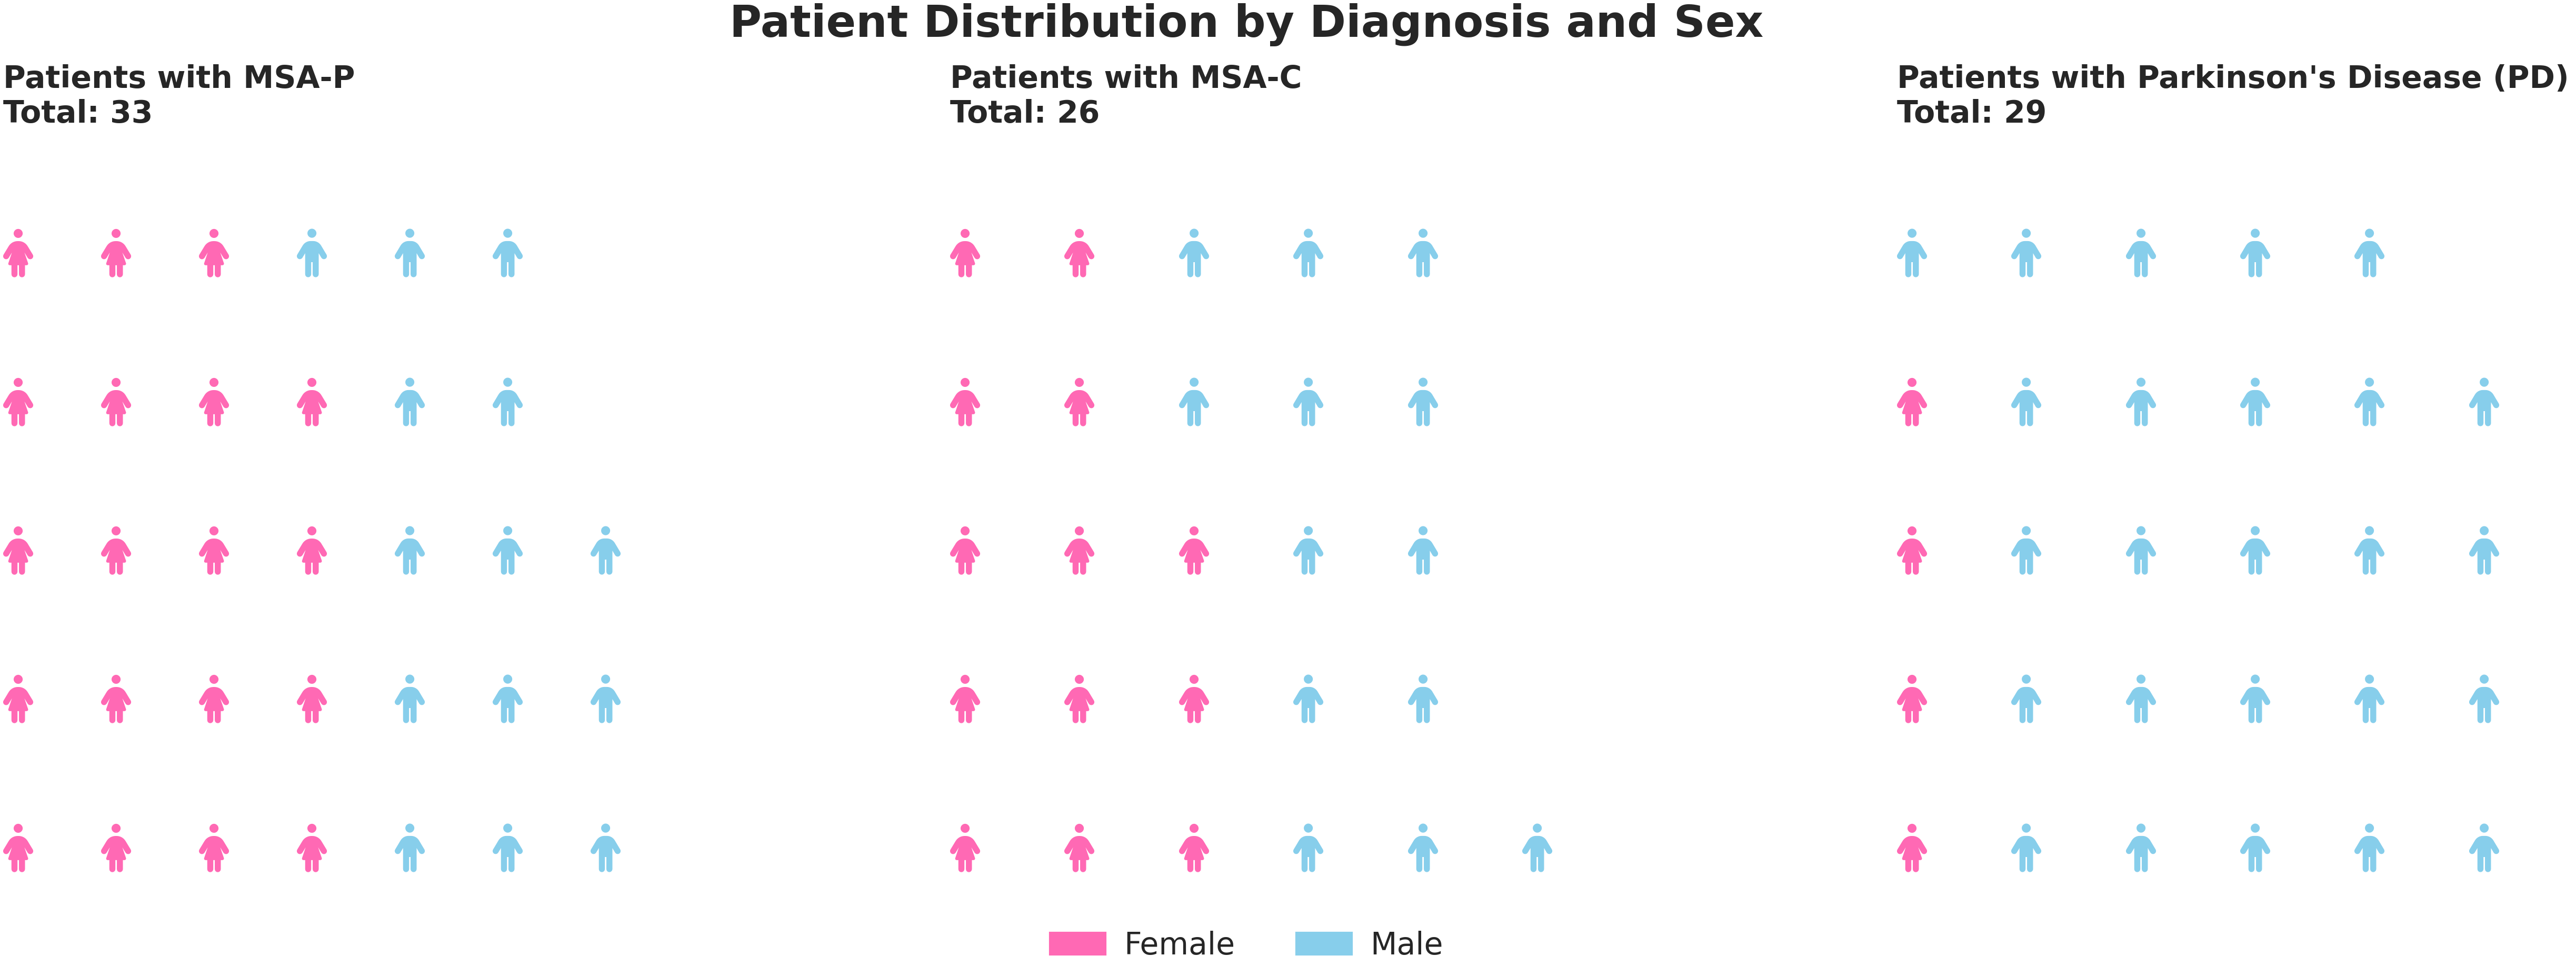

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from pywaffle import Waffle
import matplotlib.patches as mpatches

# Assumi che 'df' sia il tuo DataFrame già caricato

# --- 1. Preparazione dei Dati (Hardcoded) ---
# Calcoliamo i conteggi per ogni classe specifica che vogliamo plottare.
data_counts = pd.crosstab(df['diagnosi_definita'], df['sesso'])

# Assicuriamoci che le colonne F e M esistano e siano nell'ordine corretto
if 'F' not in data_counts.columns: data_counts['F'] = 0
if 'M' not in data_counts.columns: data_counts['M'] = 0
data_counts = data_counts[['F', 'M']]

# Estraiamo i dati per ogni singola classe
msa_p_counts = data_counts.loc['MSA-P']
msa_c_counts = data_counts.loc['MSA-C']
pd_counts = data_counts.loc['PD']


# --- 2. Creazione del Grafico (Hardcoded per 3 Classi) ---

# 👉 SEZIONE DA MODIFICARE (Passo 1: Numero di subplot)
# Imposta il numero di subplot su 3
fig, axes = plt.subplots(
    1, 3, # <--- Modifica qui per 2 o 3 classi
    figsize=(21, 6), # Aumentiamo la larghezza per fare spazio al terzo grafico
    sharey=True,
    gridspec_kw={'wspace': 0.4}
)

fig.suptitle('Patient Distribution by Diagnosis and Sex', fontsize=20, fontweight='bold', y=1.02)

# --- Chart 1: MSA-P ---
Waffle.make_waffle(
    ax=axes[0],
    rows=5,
    values=msa_p_counts,
    title={'label': f"Patients with MSA-P\nTotal: {msa_p_counts.sum()}", 'loc': 'left', 'fontdict': {'fontsize': 14, 'fontweight': 'bold'}},
    colors=["#FF69B4", "#87CEEB"],
    icons=['female', 'male'],
    font_size=22, icon_style='solid',
    interval_ratio_x=0.1, interval_ratio_y=0.1
)

# --- Chart 2: MSA-C ---
Waffle.make_waffle(
    ax=axes[1],
    rows=5,
    values=msa_c_counts,
    title={'label': f"Patients with MSA-C\nTotal: {msa_c_counts.sum()}", 'loc': 'left', 'fontdict': {'fontsize': 14, 'fontweight': 'bold'}},
    colors=["#FF69B4", "#87CEEB"],
    icons=['female', 'male'],
    font_size=22, icon_style='solid',
    interval_ratio_x=0.1, interval_ratio_y=0.1
)

# 👉 SECTION TO MODIFY (Step 2: Add/Remove Chart)
# --- Chart 3: PD ---
Waffle.make_waffle(
    ax=axes[2], # <--- Make sure the index (2) is correct
    rows=5,
    values=pd_counts,
    title={'label': f"Patients with Parkinson's Disease (PD)\nTotal: {pd_counts.sum()}", 'loc': 'left', 'fontdict': {'fontsize': 14, 'fontweight': 'bold'}},
    colors=["#FF69B4", "#87CEEB"],
    icons=['female', 'male'],
    font_size=22, icon_style='solid',
    interval_ratio_x=0.1, interval_ratio_y=0.1
)

# --- Legend and Layout (unchanged) ---
legend_handles = [
    mpatches.Patch(color='#FF69B4', label="Female"),
    mpatches.Patch(color='#87CEEB', label="Male")
]
fig.legend(handles=legend_handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=14, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.show()

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from pywaffle import Waffle
import matplotlib.patches as mpatches

# Assumi che 'df' sia il tuo DataFrame già caricato

# --- 1. PREPARAZIONE DATI: IL TUO "INTERRUTTORE" ---
# Qui decidi se visualizzare 2 o 3 classi.

# Calcola i conteggi iniziali da tutto il DataFrame
all_counts = pd.crosstab(df['diagnosi_definita'], df['sesso'])

# Ensure columns 'F' and 'M' are present and in the correct order
if 'F' not in all_counts.columns:
    all_counts['F'] = 0
if 'M' not in all_counts.columns:
    all_counts['M'] = 0
all_counts = all_counts[['F', 'M']]

# 👉 MODIFY HERE TO SWITCH BETWEEN CHARTS 👈
# For the 2-class waffle (MSA aggregated), uncomment these 3 lines:
msa_aggregated = all_counts.loc[['MSA-P', 'MSA-C']].sum()
data_counts = all_counts.drop(['MSA-P', 'MSA-C'])
data_counts.loc['MSA'] = msa_aggregated

# For the 3-class (MSA-P, MSA-C, PD) chart, uncomment this line instead (and comment the above 3):
# data_counts = all_counts

# --- 2. AUTOMATIC PLOTTING LOGIC ---
# The code below determines the number of groups/classes and draws the appropriate waffle plot.

num_classes = len(data_counts)
print(f"Detected {num_classes} classes. Preparing chart...")

# --- A) Block for 3-CLASS chart (MSA-P, MSA-C, PD) ---
if num_classes == 3:
    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True, gridspec_kw={'wspace': 0.4})
    fig.suptitle('Patient Distribution: MSA-P vs MSA-C vs PD', fontsize=20, fontweight='bold', y=1.02)

    # Chart 1: MSA-P
    Waffle.make_waffle(
        ax=axes[0],
        rows=5,
        values=data_counts.loc['MSA-P'],
        title={'label': f"Patients with MSA-P\nTotal: {data_counts.loc['MSA-P'].sum()}",
               'loc': 'left', 'fontdict': {'fontsize': 14}},
        colors=["#FF69B4", "#87CEEB"], icons=['female', 'male'], font_size=22,
        icon_style='solid', interval_ratio_x=0.1, interval_ratio_y=0.1
    )
    # Chart 2: MSA-C
    Waffle.make_waffle(
        ax=axes[1],
        rows=5,
        values=data_counts.loc['MSA-C'],
        title={'label': f"Patients with MSA-C\nTotal: {data_counts.loc['MSA-C'].sum()}",
               'loc': 'left', 'fontdict': {'fontsize': 14}},
        colors=["#FF69B4", "#87CEEB"], icons=['female', 'male'], font_size=22,
        icon_style='solid', interval_ratio_x=0.1, interval_ratio_y=0.1
    )
    # Chart 3: PD
    Waffle.make_waffle(
        ax=axes[2],
        rows=5,
        values=data_counts.loc['PD'],
        title={'label': f"Patients with Parkinson's Disease (PD)\nTotal: {data_counts.loc['PD'].sum()}",
               'loc': 'left', 'fontdict': {'fontsize': 14}},
        colors=["#FF69B4", "#87CEEB"], icons=['female', 'male'], font_size=22,
        icon_style='solid', interval_ratio_x=0.1, interval_ratio_y=0.1
    )

# --- B) Block for 2-CLASS chart (MSA, PD) ---
elif num_classes == 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={'wspace': 0.4})
    fig.suptitle('Patient Distribution: MSA vs PD', fontsize=20, fontweight='bold', y=1.02)

    # Chart 1: MSA (aggregated)
    Waffle.make_waffle(
        ax=axes[0],
        rows=5,
        values=data_counts.loc['MSA'],
        title={'label': f"Patients with Multiple System Atrophy (MSA)\nTotal: {data_counts.loc['MSA'].sum()}",
               'loc': 'left', 'fontdict': {'fontsize': 14}},
        colors=["#FF69B4", "#87CEEB"], icons=['female', 'male'], font_size=22,
        icon_style='solid', interval_ratio_x=0.1, interval_ratio_y=0.1
    )
    # Chart 2: PD
    Waffle.make_waffle(
        ax=axes[1],
        rows=5,
        values=data_counts.loc['PD'],
        title={'label': f"Patients with Parkinson's Disease (PD)\nTotal: {data_counts.loc['PD'].sum()}",
               'loc': 'left', 'fontdict': {'fontsize': 14}},
        colors=["#FF69B4", "#87CEEB"], icons=['female', 'male'], font_size=22,
        icon_style='solid', interval_ratio_x=0.1, interval_ratio_y=0.1
    )

else:
    print(f"ERROR: This code is set up for 2 or 3 classes, but {num_classes} were found. Please check the data preparation.")
    exit()

# --- 3. LEGEND & LAYOUT (shared for both chart types) ---
legend_handles = [
    mpatches.Patch(color='#FF69B4', label="Female"),
    mpatches.Patch(color='#87CEEB', label="Male")
]
fig.legend(handles=legend_handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02),
           fontsize=14, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.show()

Detected 2 classes. Preparing chart...


/tmp/ipykernel_20904/876416006.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.9])


STEP 1: DISTRIBUZIONE PAZIENTI PER DIAGNOSI DEFINITIVA

📊 CONTEGGIO PAZIENTI PER DIAGNOSI:

diagnosi_definita
MSA-P    33
PD       29
MSA-C    26

────────────────────────────────────────
TOTALE PAZIENTI: 88
────────────────────────────────────────

📈 PERCENTUALI:

  MSA-P     :  33 pazienti ( 37.5%)  ██████████████████
  PD        :  29 pazienti ( 33.0%)  ████████████████
  MSA-C     :  26 pazienti ( 29.5%)  ██████████████

✅ Figure saved: distribuzione_diagnosi.png


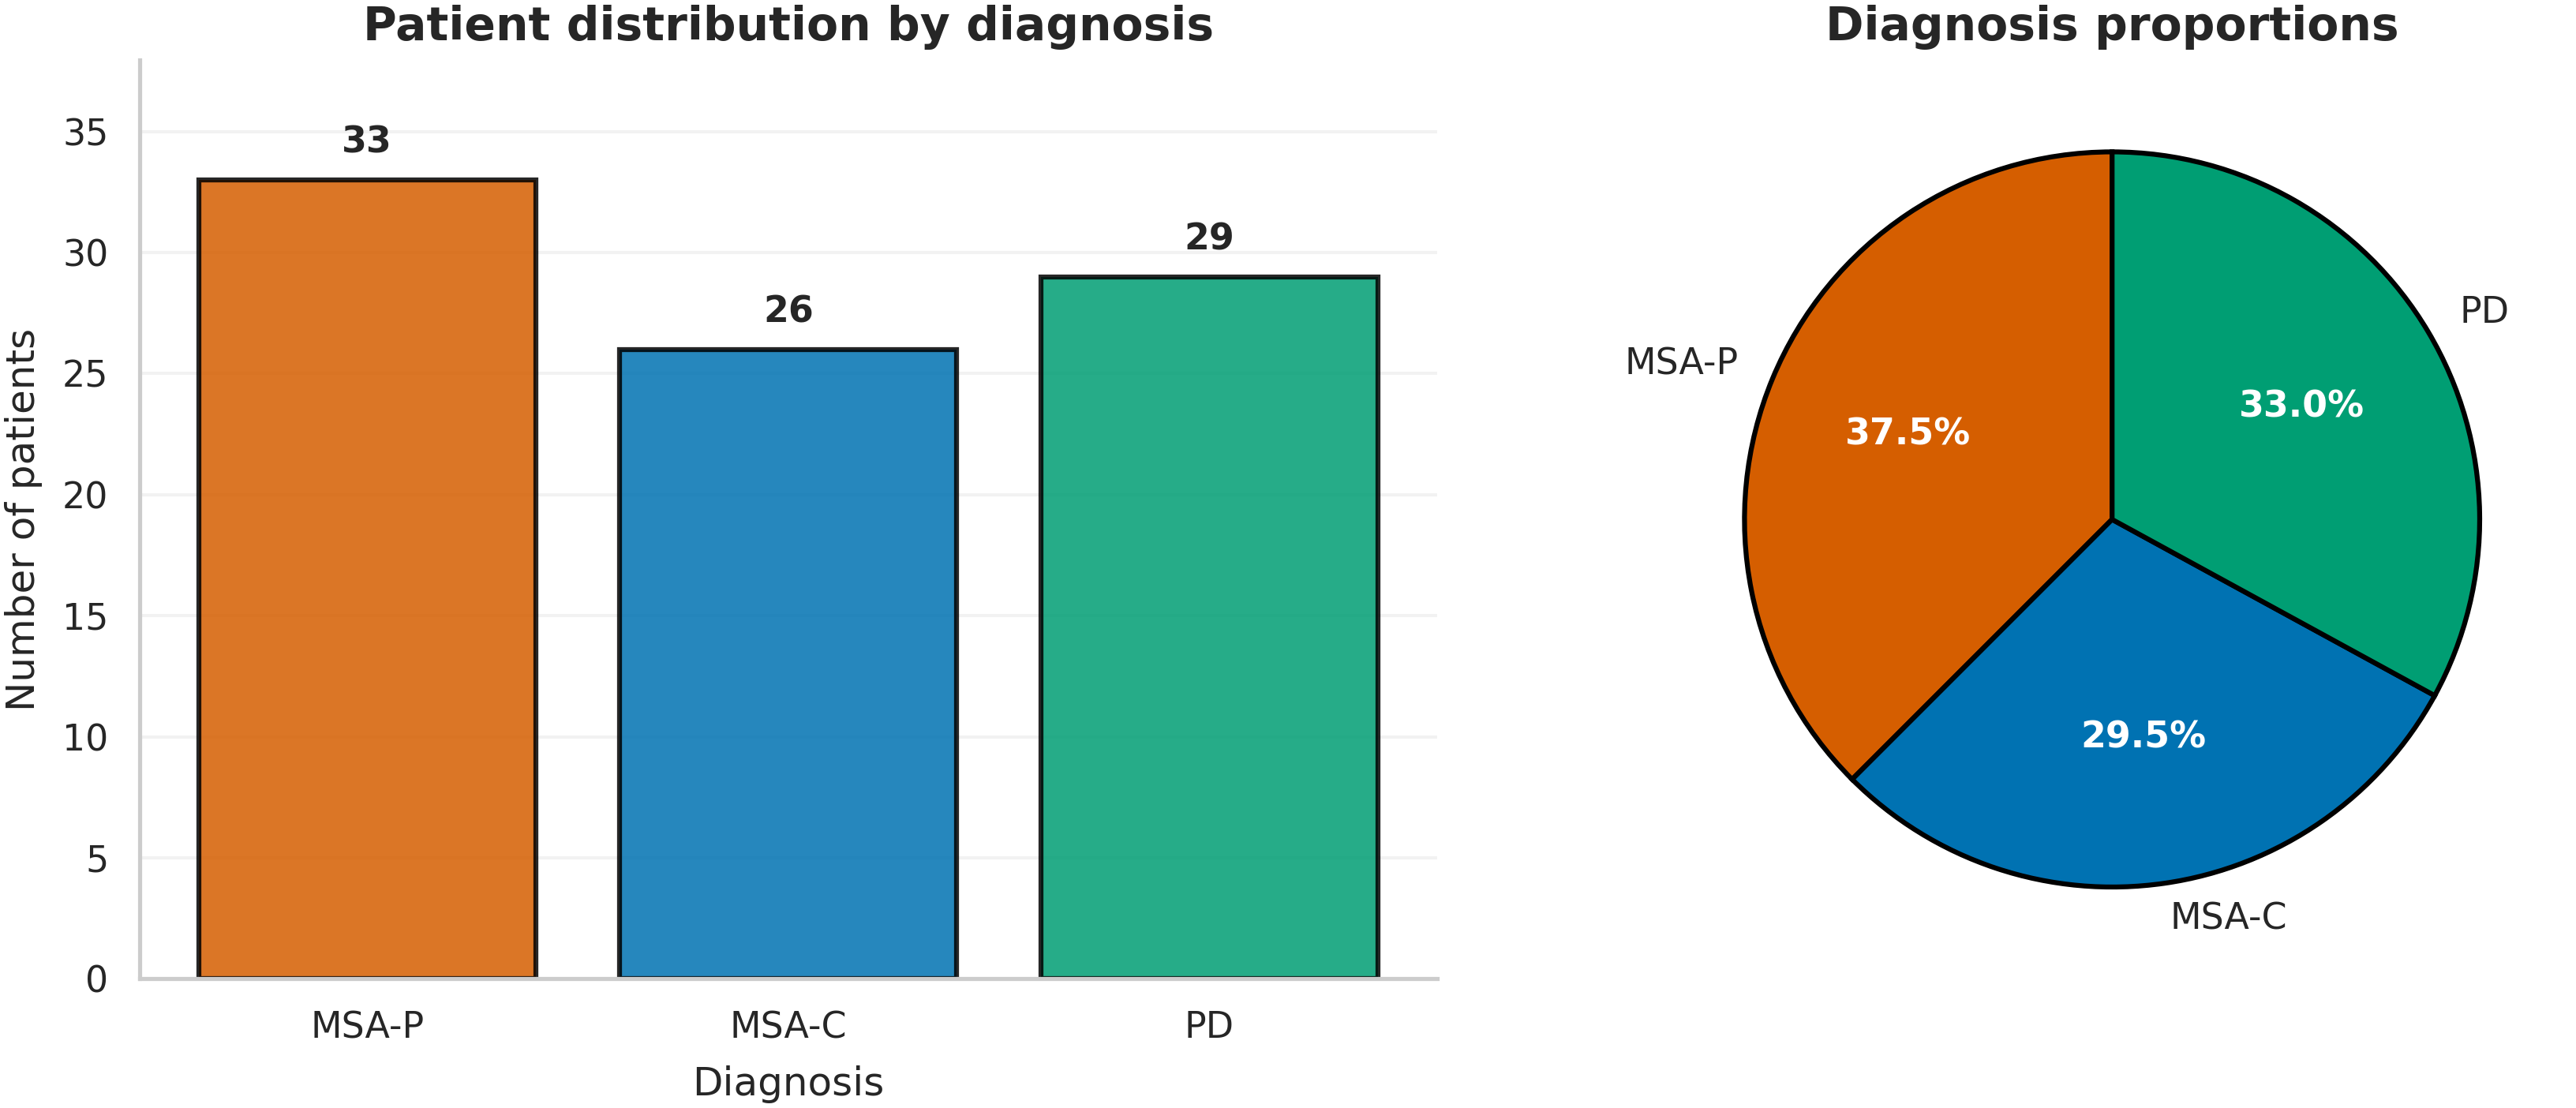

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add parent directory to path to import style module
parent_dir = Path('.').resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from style.style_manager import StyleManager

# Initialize and activate thesis style with absolute path
mplstyle_path = parent_dir / 'style' / 'thesis_style.mplstyle'
sm = StyleManager(mplstyle_path=str(mplstyle_path))
sm.activate()

# Clean the data - remove empty rows
# Keep only rows with a valid patient id (CODICE is now the index)
df_clean = df.loc[df.index.notna()].copy()
df_clean = df_clean.dropna(subset=['diagnosi_definita'])

# Clean diagnosis column - remove extra spaces and standardize names
df_clean['diagnosi_definita'] = df_clean['diagnosi_definita'].str.strip()

print("=" * 70)
print("STEP 1: DISTRIBUZIONE PAZIENTI PER DIAGNOSI DEFINITIVA")
print("=" * 70)

# Count patients by diagnosis
diagnosis_counts = df_clean['diagnosi_definita'].value_counts().sort_values(ascending=False)

print(f"\n📊 CONTEGGIO PAZIENTI PER DIAGNOSI:\n")
print(diagnosis_counts.to_string())
print(f"\n{'─' * 40}")
print(f"TOTALE PAZIENTI: {len(df_clean)}")
print(f"{'─' * 40}")

# Calculate percentages
print(f"\n📈 PERCENTUALI:\n")
for diag, count in diagnosis_counts.items():
    percentage = (count / len(df_clean)) * 100
    bar = '█' * int(percentage / 2)  # Visual bar
    print(f"  {diag:10s}: {count:3d} pazienti ({percentage:5.1f}%)  {bar}")

# Create visualization with thesis style
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Use consistent class order and colors from active StyleManager palette
# This automatically adapts when you switch between Okabe-Ito and POLIMI palettes
class_order = ['MSA-P', 'MSA-C', 'PD']
colors_dict = {
    'MSA-P': sm.palette[1],  # Second color in palette (vermillion/teal-green)
    'MSA-C': sm.palette[0],  # First color in palette (blue/deep navy)
    'PD': sm.palette[2]      # Third color in palette (green/dark orange)
}

# Reorder diagnosis_counts to follow class_order
diagnosis_ordered = diagnosis_counts.reindex(class_order, fill_value=0)
bar_colors = [colors_dict[diag] for diag in diagnosis_ordered.index]

# Plot 1: Bar chart
bars = ax1.bar(
    diagnosis_ordered.index, 
    diagnosis_ordered.values, 
    color=bar_colors,
    edgecolor='black', 
    linewidth=1.5, 
    alpha=0.85
)

# Add value labels on bars
for i, (diag, count) in enumerate(diagnosis_ordered.items()):
    ax1.text(i, count + 0.8, str(count), 
             ha='center', va='bottom', 
             fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of patients', fontsize=12)
ax1.set_xlabel('Diagnosis', fontsize=12)
ax1.set_title('Patient distribution by diagnosis', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(diagnosis_ordered.values) * 1.15)

# Remove top and right spines (minimalist aesthetic)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Pie chart
wedges, texts, autotexts = ax2.pie(
    diagnosis_ordered.values, 
    labels=diagnosis_ordered.index,
    autopct='%1.1f%%',
    colors=bar_colors, 
    startangle=90,
    textprops={'fontsize': 11},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_color('white')

ax2.set_title('Diagnosis proportions', fontsize=14, fontweight='bold')

plt.tight_layout()

# Save using StyleManager (300 DPI, transparent, tight layout)
sm.savefig('distribuzione_diagnosi.png')
print(f"\n✅ Figure saved: distribuzione_diagnosi.png")
plt.show()

# Store cleaned dataframe for next steps
df = df_clean

In [71]:
count_series = df.groupby('diagnosi_definita')['sesso'].value_counts()
# display(count_series)
print(count_series)

diagnosi_definita  sesso
MSA-C              F        13
                   M        13
MSA-P              F        19
                   M        14
PD                 M        25
                   F         4
Name: count, dtype: int64


In [72]:
# =============================================================================
# PIE CHART VISUALIZATION - SEX DISTRIBUTION BY DIAGNOSIS
# Following thesis plotting standards
# =============================================================================

from style.style_manager import StyleManager
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


print("=" * 60)
print("SEX DISTRIBUTION BY DIAGNOSIS - PIE CHARTS")
print("=" * 60)


# Get unique diagnoses
diagnoses = count_series.index.get_level_values('diagnosi_definita').unique()

# Create subplots with proper spacing
fig, axes = plt.subplots(1, len(diagnoses), figsize=(15, 6))
if len(diagnoses) == 1:
    axes = [axes]

# Use your preferred colors - CONSISTENT ORDER
colors = ["#FF69B4", "#87CEEB"]  # Hot pink for Female, Sky blue for Male

for i, diagnosis in enumerate(diagnoses):
    # Get data for this diagnosis
    diag_data = count_series[diagnosis]
    
    # Ensure consistent color mapping by sorting the data
    # This ensures F always gets the first color and M gets the second color
    diag_data_sorted = diag_data.sort_index()
    
    # Create pie chart
    wedges, texts, autotexts = axes[i].pie(diag_data_sorted.values, 
                                           labels=diag_data_sorted.index,
                                           colors=colors[:len(diag_data_sorted)],
                                           autopct='%1.1f%%',
                                           startangle=90,
                                           textprops={'fontsize': 10, 'fontweight': 'bold'})
    
    # Customize text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    # Set title with proper spacing (sentence case)
    axes[i].set_title(f'{diagnosis}\n(n={diag_data.sum()})', 
                     fontsize=12, fontweight='bold', pad=30)

# Add overall title with much more space to prevent overlap
fig.suptitle('Sex distribution by diagnosis', 
            fontsize=14, fontweight='bold', y=1.02)  # Moved much higher

# Adjust layout to prevent title overlap - give more space
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Much more space for main title

# Save figure following thesis standards
sm.savefig("../images/sex_distribution_by_diagnosis_pie_charts.png")

# Display the figure
plt.show()

SEX DISTRIBUTION BY DIAGNOSIS - PIE CHARTS


## DISTRIBUZIONI

In [ ]:
df.columns.to_list()

['sesso',
 'data_di_nascita',
 'diagnosi_di_invio',
 'diagnosi_definita',
 'annotazioni_su_diagnosi_finale',
 'anno_diagnosi',
 'anno_esordio_sintomi_motori',
 'anno_esordio_sintomi_non_motori',
 'anno_esordio_disautonomia',
 'eta_esordio',
 'durata_malattia',
 'anni_l_dopa',
 'anni_dopaminoaagonisti',
 'ledd',
 'updrs_on',
 'updrs_off',
 'delta_off_on',
 'h_and_y',
 'deambulaz_autonoma',
 'deambulaz_appoggio',
 'carrozzina',
 'cadute',
 'compass_totale',
 'compass_oh',
 'compass_vasc',
 'compass_sudor',
 'compass_gi',
 'compass_uin',
 'compass_pupil',
 'parkinsonism',
 'poor_l_dopa_responsivenes',
 'cerebellar_syndrome',
 'rapid_progression_w_3_yrs',
 'moderate_to_severe_postural_instability_w_3_yrs_of_motor_onset',
 'craniocervical_dyst_induced_dy_l_dopa',
 'severe_speech_impairement_w_3_yrs',
 'severe_dysphagia_w_3_yrs',
 'unexplained_babinski',
 'jerky_myoclonic_postural_or_kinetic_tremor',
 'postural_deformities',
 'tipo_deformita',
 'fog',
 'unexplained_voiding_difficulties',
 'u

In [ ]:
# =============================================================================
# COMPREHENSIVE VISUALIZATIONS FOR AGE AND DISEASE DURATION
# =============================================================================
print("\n📊 Creating visualizations...\n")

# In your notebook
from clinica.utils import (
    create_violin_plots,
    create_histogram_plots,
    create_table_image,
    create_summary_table
)


sns.set_theme(style="whitegrid", palette=sm.palette)
# Create figures directory if it doesn't exist
os.makedirs("figures", exist_ok=True)

print("=" * 80)
print("AGE AND DISEASE DURATION DISTRIBUTIONS - COMPREHENSIVE VISUALIZATION")
print("=" * 80)

# Prepare the data
# Ensure column names are correct - adjust if needed
age_col = 'eta_attuale'  # or 'Età esordio' for age at onset
duration_col = 'durata_malattia'
diagnosis_col = 'diagnosi_definita'  # or 'Diagnosi DEFINITA' - adjust based on your df

class_order = CLASSES_ORDER
colors_dict = {
    'MSA-P': sm.palette[1],  # Second color in palette (vermillion/teal-green)
    'MSA-C': sm.palette[0],  # First color in palette (blue/deep navy)
    'PD': sm.palette[2]      # Third color in palette (green/dark orange)
}

# Generate plots
fig1 = create_violin_plots(df, age_col, duration_col, diagnosis_col, colors_dict)
fig2 = create_histogram_plots(df, age_col, duration_col, diagnosis_col, colors_dict)

# Save figures
# Save figures - make each figure current before saving
plt.figure(fig1.number)  # Make fig1 the current figure
sm.savefig(f"{IMAGES_SAVE_PATH}/age_duration_violin_plots2.png")

plt.figure(fig2.number)  # Make fig2 the current figure
sm.savefig(f"{IMAGES_SAVE_PATH}/age_duration_histograms2.png")

# Display summary table
print("\n" + "=" * 80)
print("📊 STATISTICAL SUMMARY TABLE")
print("=" * 80)
summary_table = create_summary_table(df, age_col, duration_col, diagnosis_col)
print(summary_table.to_string(index=False))
print("=" * 80)

plt.show()

print("\n✅ All visualizations completed successfully!")
print("📁 Figures saved:")
print("   - .image/age_duration_violin_plots.png")
print("   - figures/age_duration_histograms.png")



In [ ]:
# Create a professional table visualization for export
from clinica.utils.tables import create_table_image
# Example: Create summary statistics table
summary_data = []
for diag in CLASSES_ORDER:
    subset = df[df['diagnosi_definita'] == diag]
    
    row = {
        'Diagnosis': diag,
        'N': len(subset),
        'M/F': f"{len(subset[subset['sesso'] == 'M'])}/{len(subset[subset['sesso'] == 'F'])}",
        'Age onset': f"{subset['eta_esordio'].mean():.1f}±{subset['eta_esordio'].std():.1f}",
        'Duration': f"{subset['durata_malattia'].mean():.1f}±{subset['durata_malattia'].std():.1f}",
        'Current age': f"{subset['eta_attuale'].mean():.1f}±{subset['eta_attuale'].std():.1f}"
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Create and save the table image
create_table_image(
    summary_df, 
    'Clinical and Demographic Characteristics by Diagnosis',
    f'{IMAGES_SAVE_PATH}/summary_table.png'
)

# LDOPA RESPONSE

## 4. Motor Function and L-dopa Responsiveness

**Objective:** Compare motor severity (UPDRS OFF) and treatment response across diagnoses.

**Clinical Relevance:**
- **UPDRS OFF score:** Measures motor impairment without medication, reflecting disease severity
- **L-dopa responsiveness:** **KEY DIAGNOSTIC CRITERION** distinguishing MSA from PD
  - PD: Typically >30% improvement with L-dopa (good response)
  - MSA: Poor L-dopa response (<30% improvement) is a core diagnostic feature

**Clinical Importance:**
This is one of the most critical clinical differentiators between MSA and PD. According to current diagnostic criteria (Gilman et al., 2008; Wenning et al., 2022), poor L-dopa response is a **red flag** for MSA and helps distinguish it from PD, which characteristically shows good initial response to dopaminergic therapy.

**Expected Findings:**
- Similar or higher UPDRS OFF scores in MSA (more severe motor impairment)
- Significantly lower L-dopa response in MSA vs. PD
- High inter-individual variability, especially in MSA

**Results**
- expected finding one and two are respected
- although MSA-P presents outliers it doesnt show higher variability than PD

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


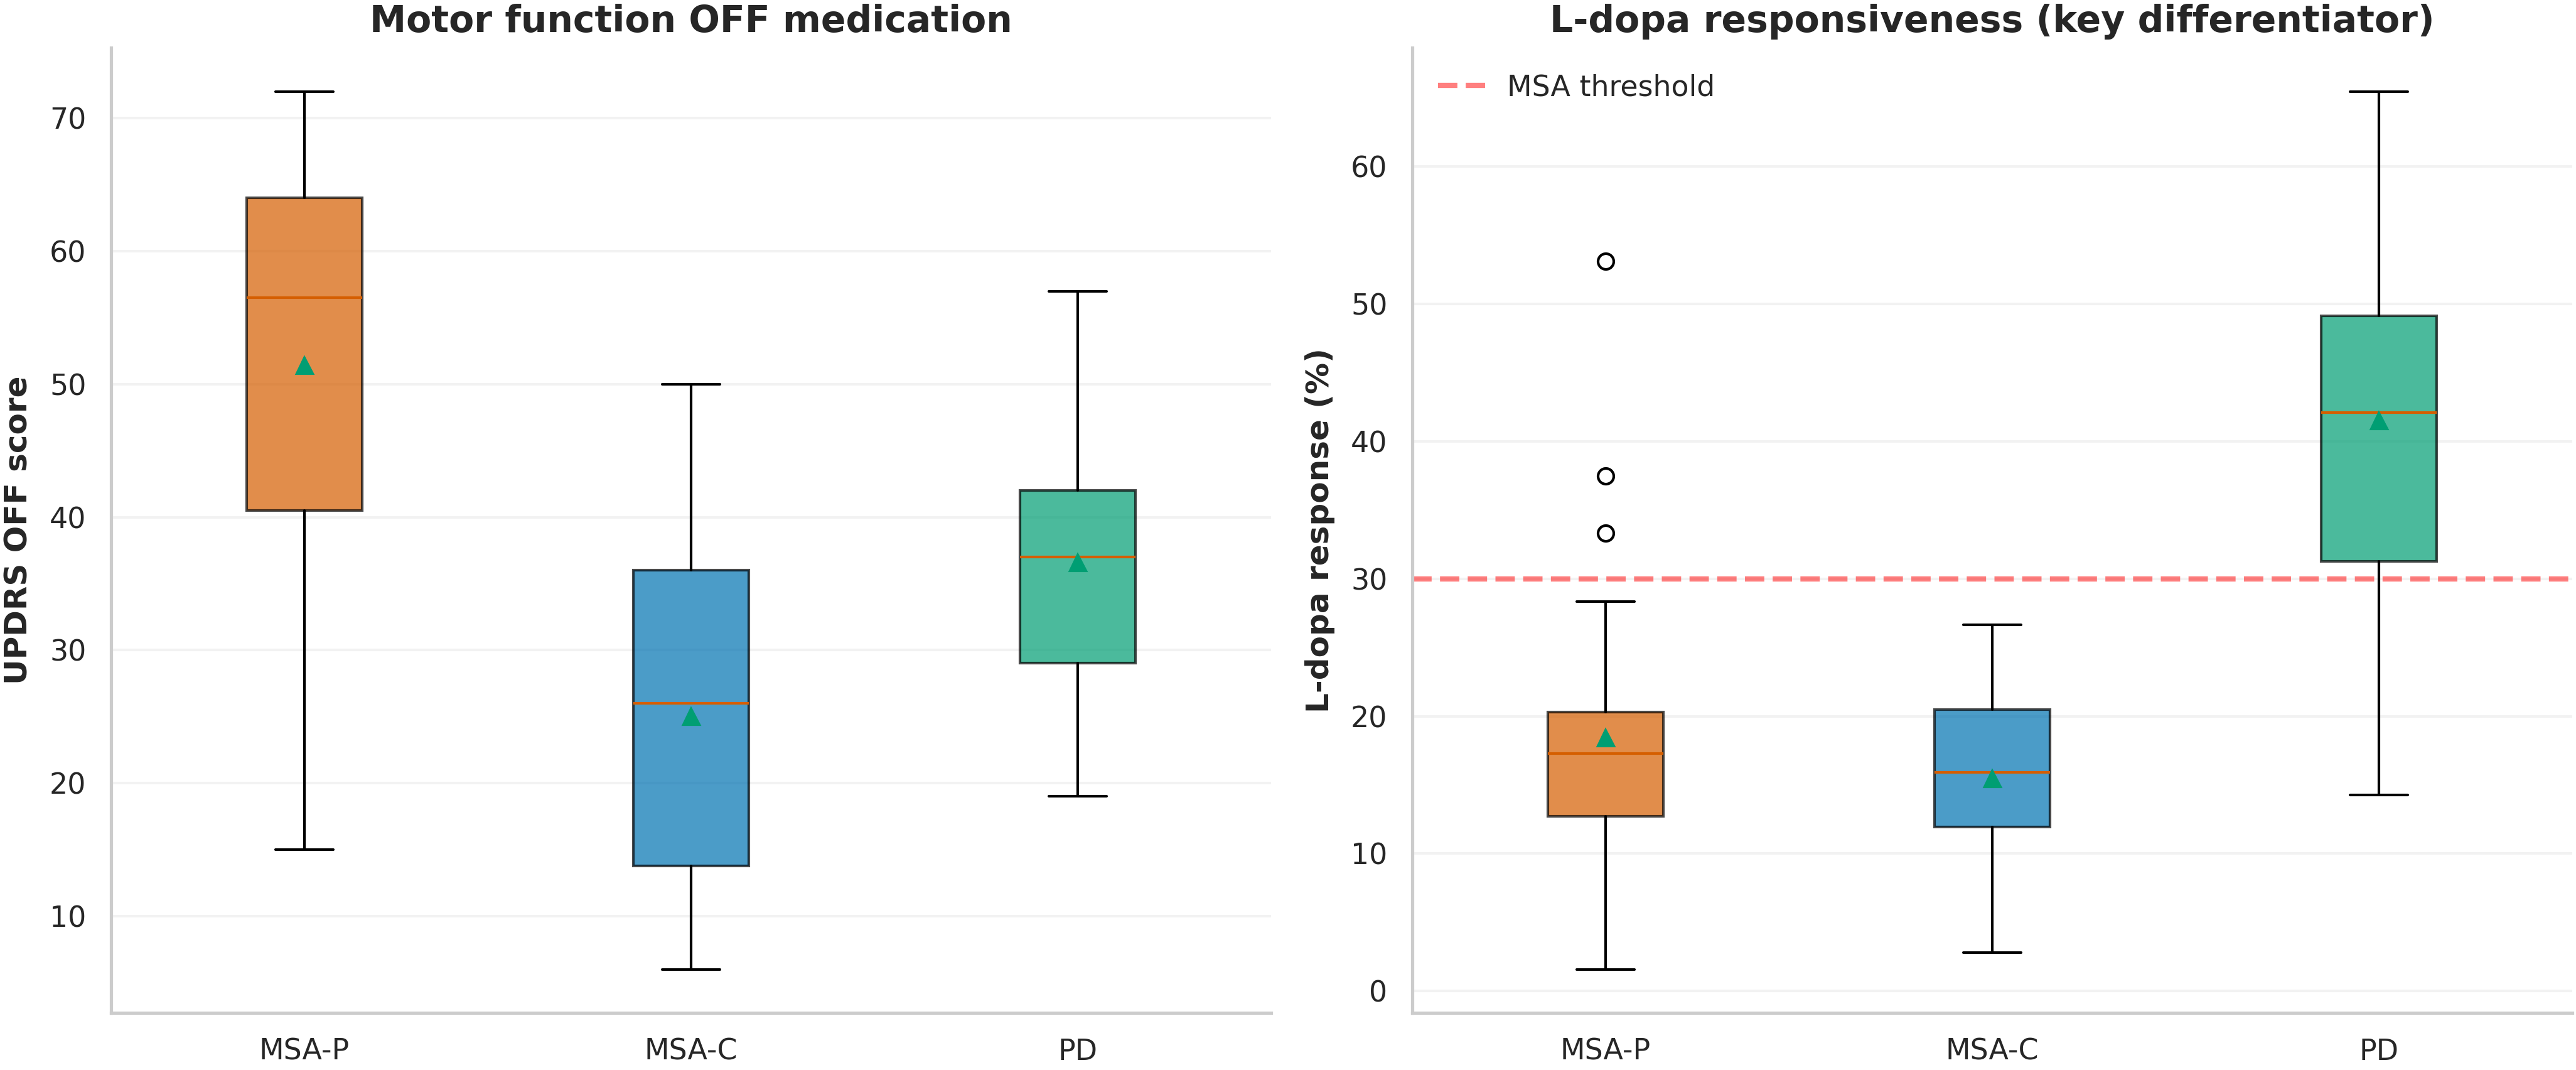

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [126]:
# UPDRS ON vs OFF comparison by diagnosis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: UPDRS OFF comparison
ax = axes[0]
data_to_plot = [df[df['diagnosi_definita'] == diag]['updrs_off'].dropna() 
                for diag in CLASSES_ORDER]

bp = ax.boxplot(data_to_plot, labels=CLASSES_ORDER, 
                patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], [colors_dict[d] for d in CLASSES_ORDER]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    
ax.set_ylabel('UPDRS OFF score', fontsize=12, fontweight='bold')
ax.set_title('Motor function OFF medication', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 2: L-dopa response percentage
ax = axes[1]
data_to_plot = [df[df['diagnosi_definita'] == diag]['percentuale_risposta_ldopa'].dropna() 
                for diag in CLASSES_ORDER]

bp = ax.boxplot(data_to_plot, labels=CLASSES_ORDER, 
                patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], [colors_dict[d] for d in CLASSES_ORDER]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('L-dopa response (%)', fontsize=12, fontweight='bold')
ax.set_title('L-dopa responsiveness (key differentiator)', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=30, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MSA threshold')
ax.legend()

plt.tight_layout()
sm.savefig('clinical_scores_comparison.png')
display(Image('clinical_scores_comparison.png'))
plt.show()

# 5. MSA Red Flags and Disease Severity (Hoehn & Yahr)

**Objective:** Quantify MSA-specific clinical red flags and assess disease staging.

**Clinical Relevance:**
- **Red flags:** Clinical features suggestive of MSA (e.g., rapid progression, early autonomic failure, poor L-dopa response, cerebellar signs)
- **Hoehn & Yahr (H&Y) staging:** Standard PD staging system (0-5), also applicable to parkinsonian disorders
  - Stage 1-2: Unilateral/bilateral involvement, no balance impairment
  - Stage 3: Balance impairment, physically independent
  - Stage 4-5: Severe disability, wheelchair-bound

**Diagnostic Significance:**
The number of red flags is a strong predictor of MSA diagnosis. Current MDS criteria require specific combinations of red flags for probable/definite MSA classification.

**Expected Findings:**
- MSA patients show significantly more red flags than PD
- MSA patients present with higher H&Y stages (faster progression)
- MSA-C may show distinct red flag patterns from MSA-P

**Results**
all expected findings are supported by data:
- MSA patients have higher means and std than PD patients
- MSA patients have higher H&Y stages


The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


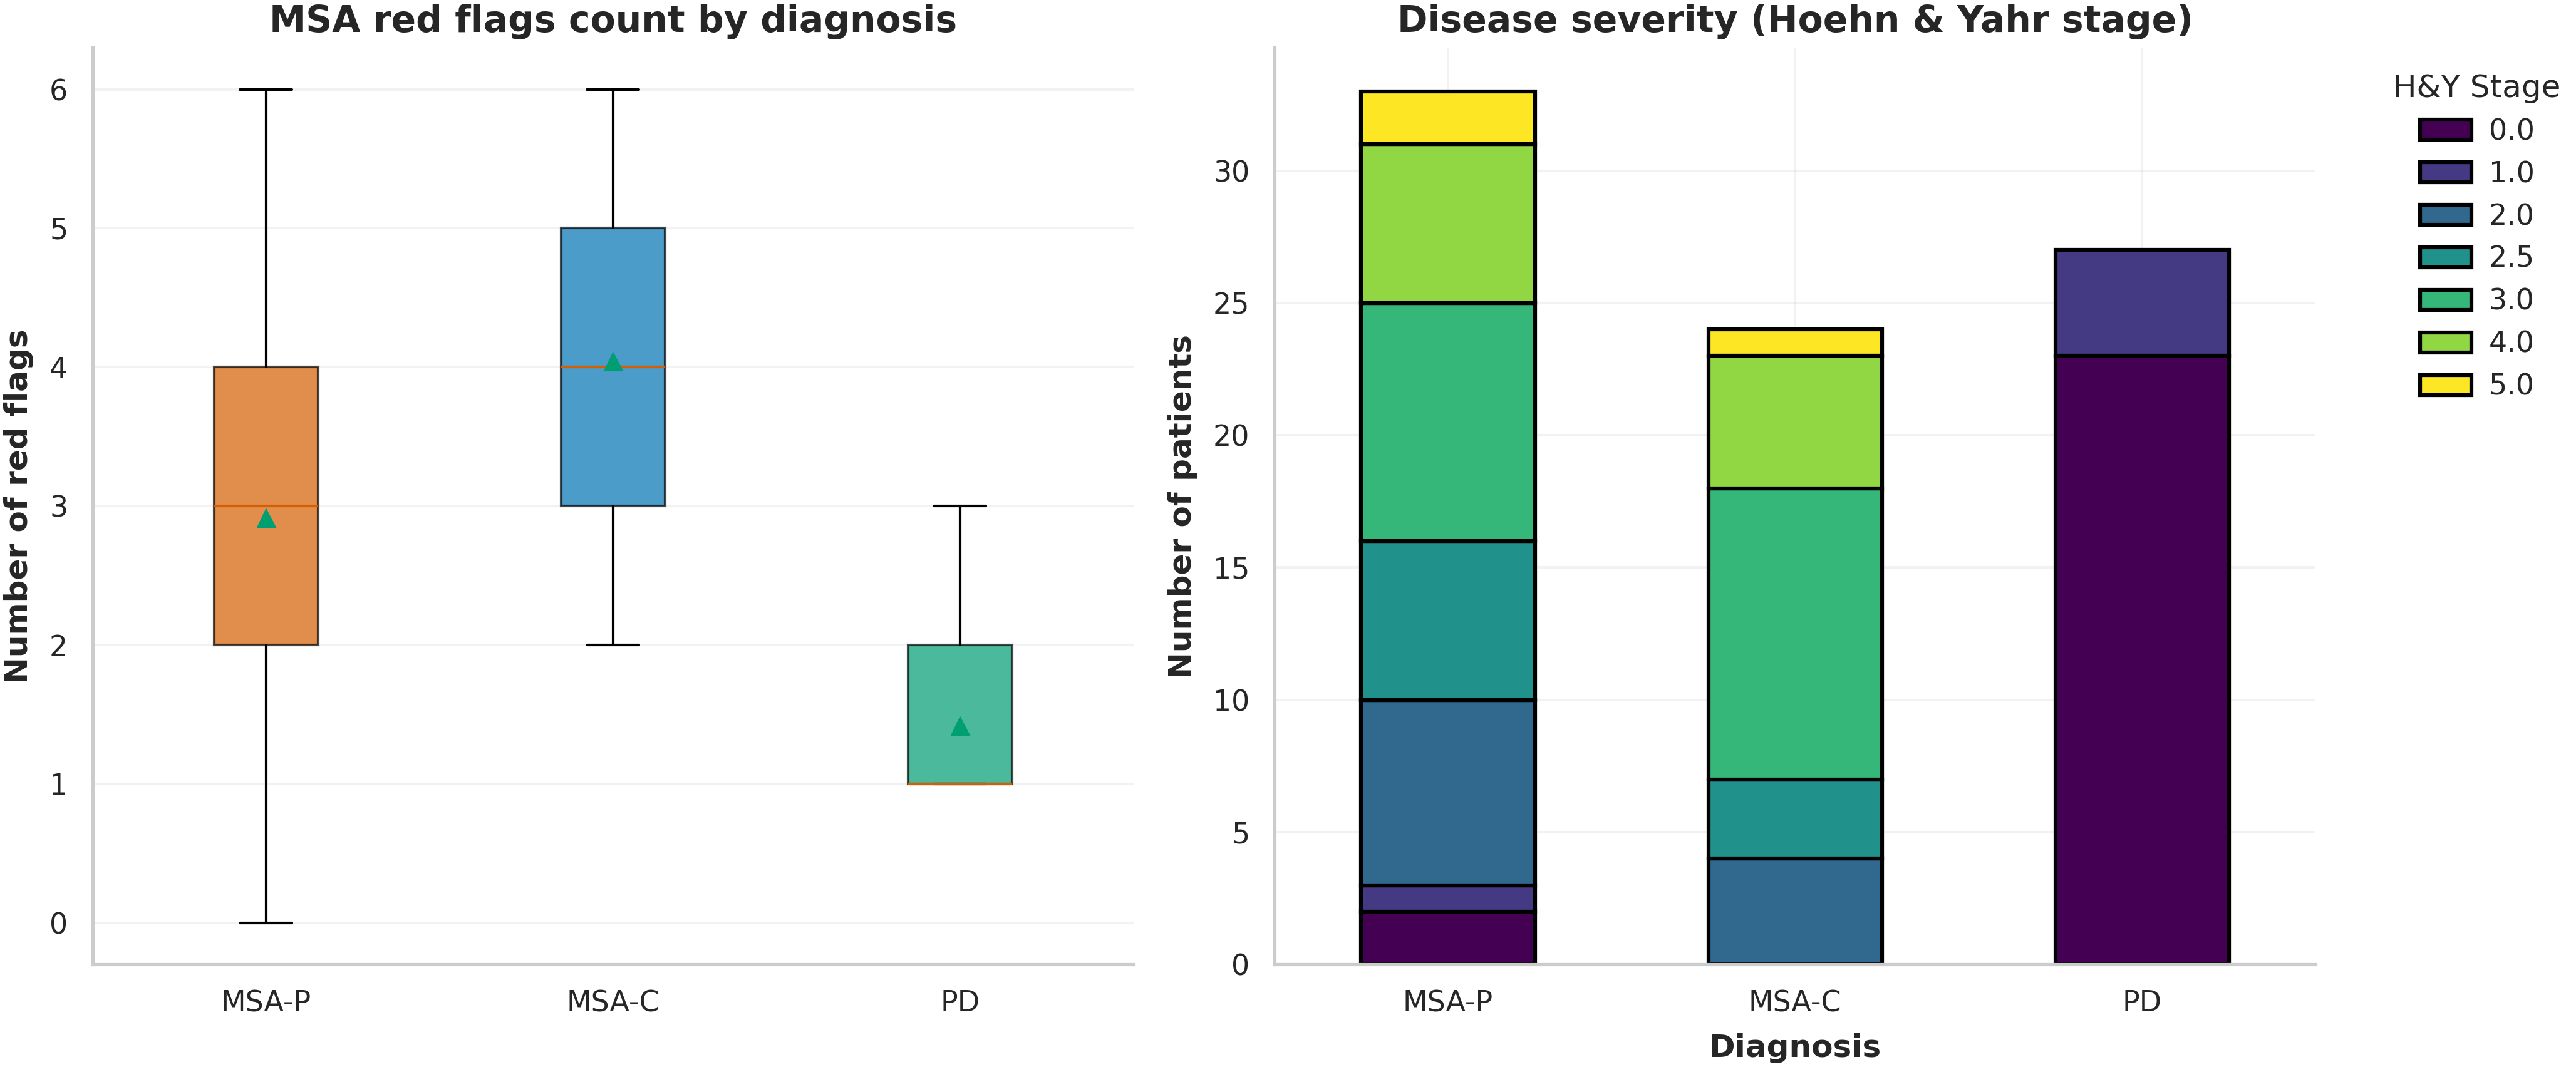

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [ ]:
# Red flags count comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Number of MSA red flags   #list of Pandas series
data_to_plot = [df[df['diagnosi_definita'] == diag]['n_red_flags_msa'].dropna() 
                for diag in CLASSES_ORDER]

bp = ax1.boxplot(data_to_plot, labels=CLASSES_ORDER, patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], [colors_dict[d] for d in CLASSES_ORDER]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    
ax1.set_ylabel('Number of red flags', fontsize=12, fontweight='bold')
ax1.set_title('MSA red flags count by diagnosis', fontsize=14, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Hoehn & Yahr stage
h_y_counts = df.groupby(['diagnosi_definita', 'h_and_y']).size().unstack(fill_value=0)
h_y_counts = h_y_counts.reindex(CLASSES_ORDER, fill_value=0)

h_y_counts.plot(kind='bar', ax=ax2, stacked=True, 
                colormap='viridis', edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of patients', fontsize=12, fontweight='bold')
ax2.set_xlabel('Diagnosis', fontsize=12, fontweight='bold')
ax2.set_title('Disease severity (Hoehn & Yahr stage)', fontsize=14, fontweight='bold')
ax2.legend(title='H&Y Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/red_flags_severity.png')
display(Image(f'{IMAGES_SAVE_PATH}/red_flags_severity.png'))
# plt.show()

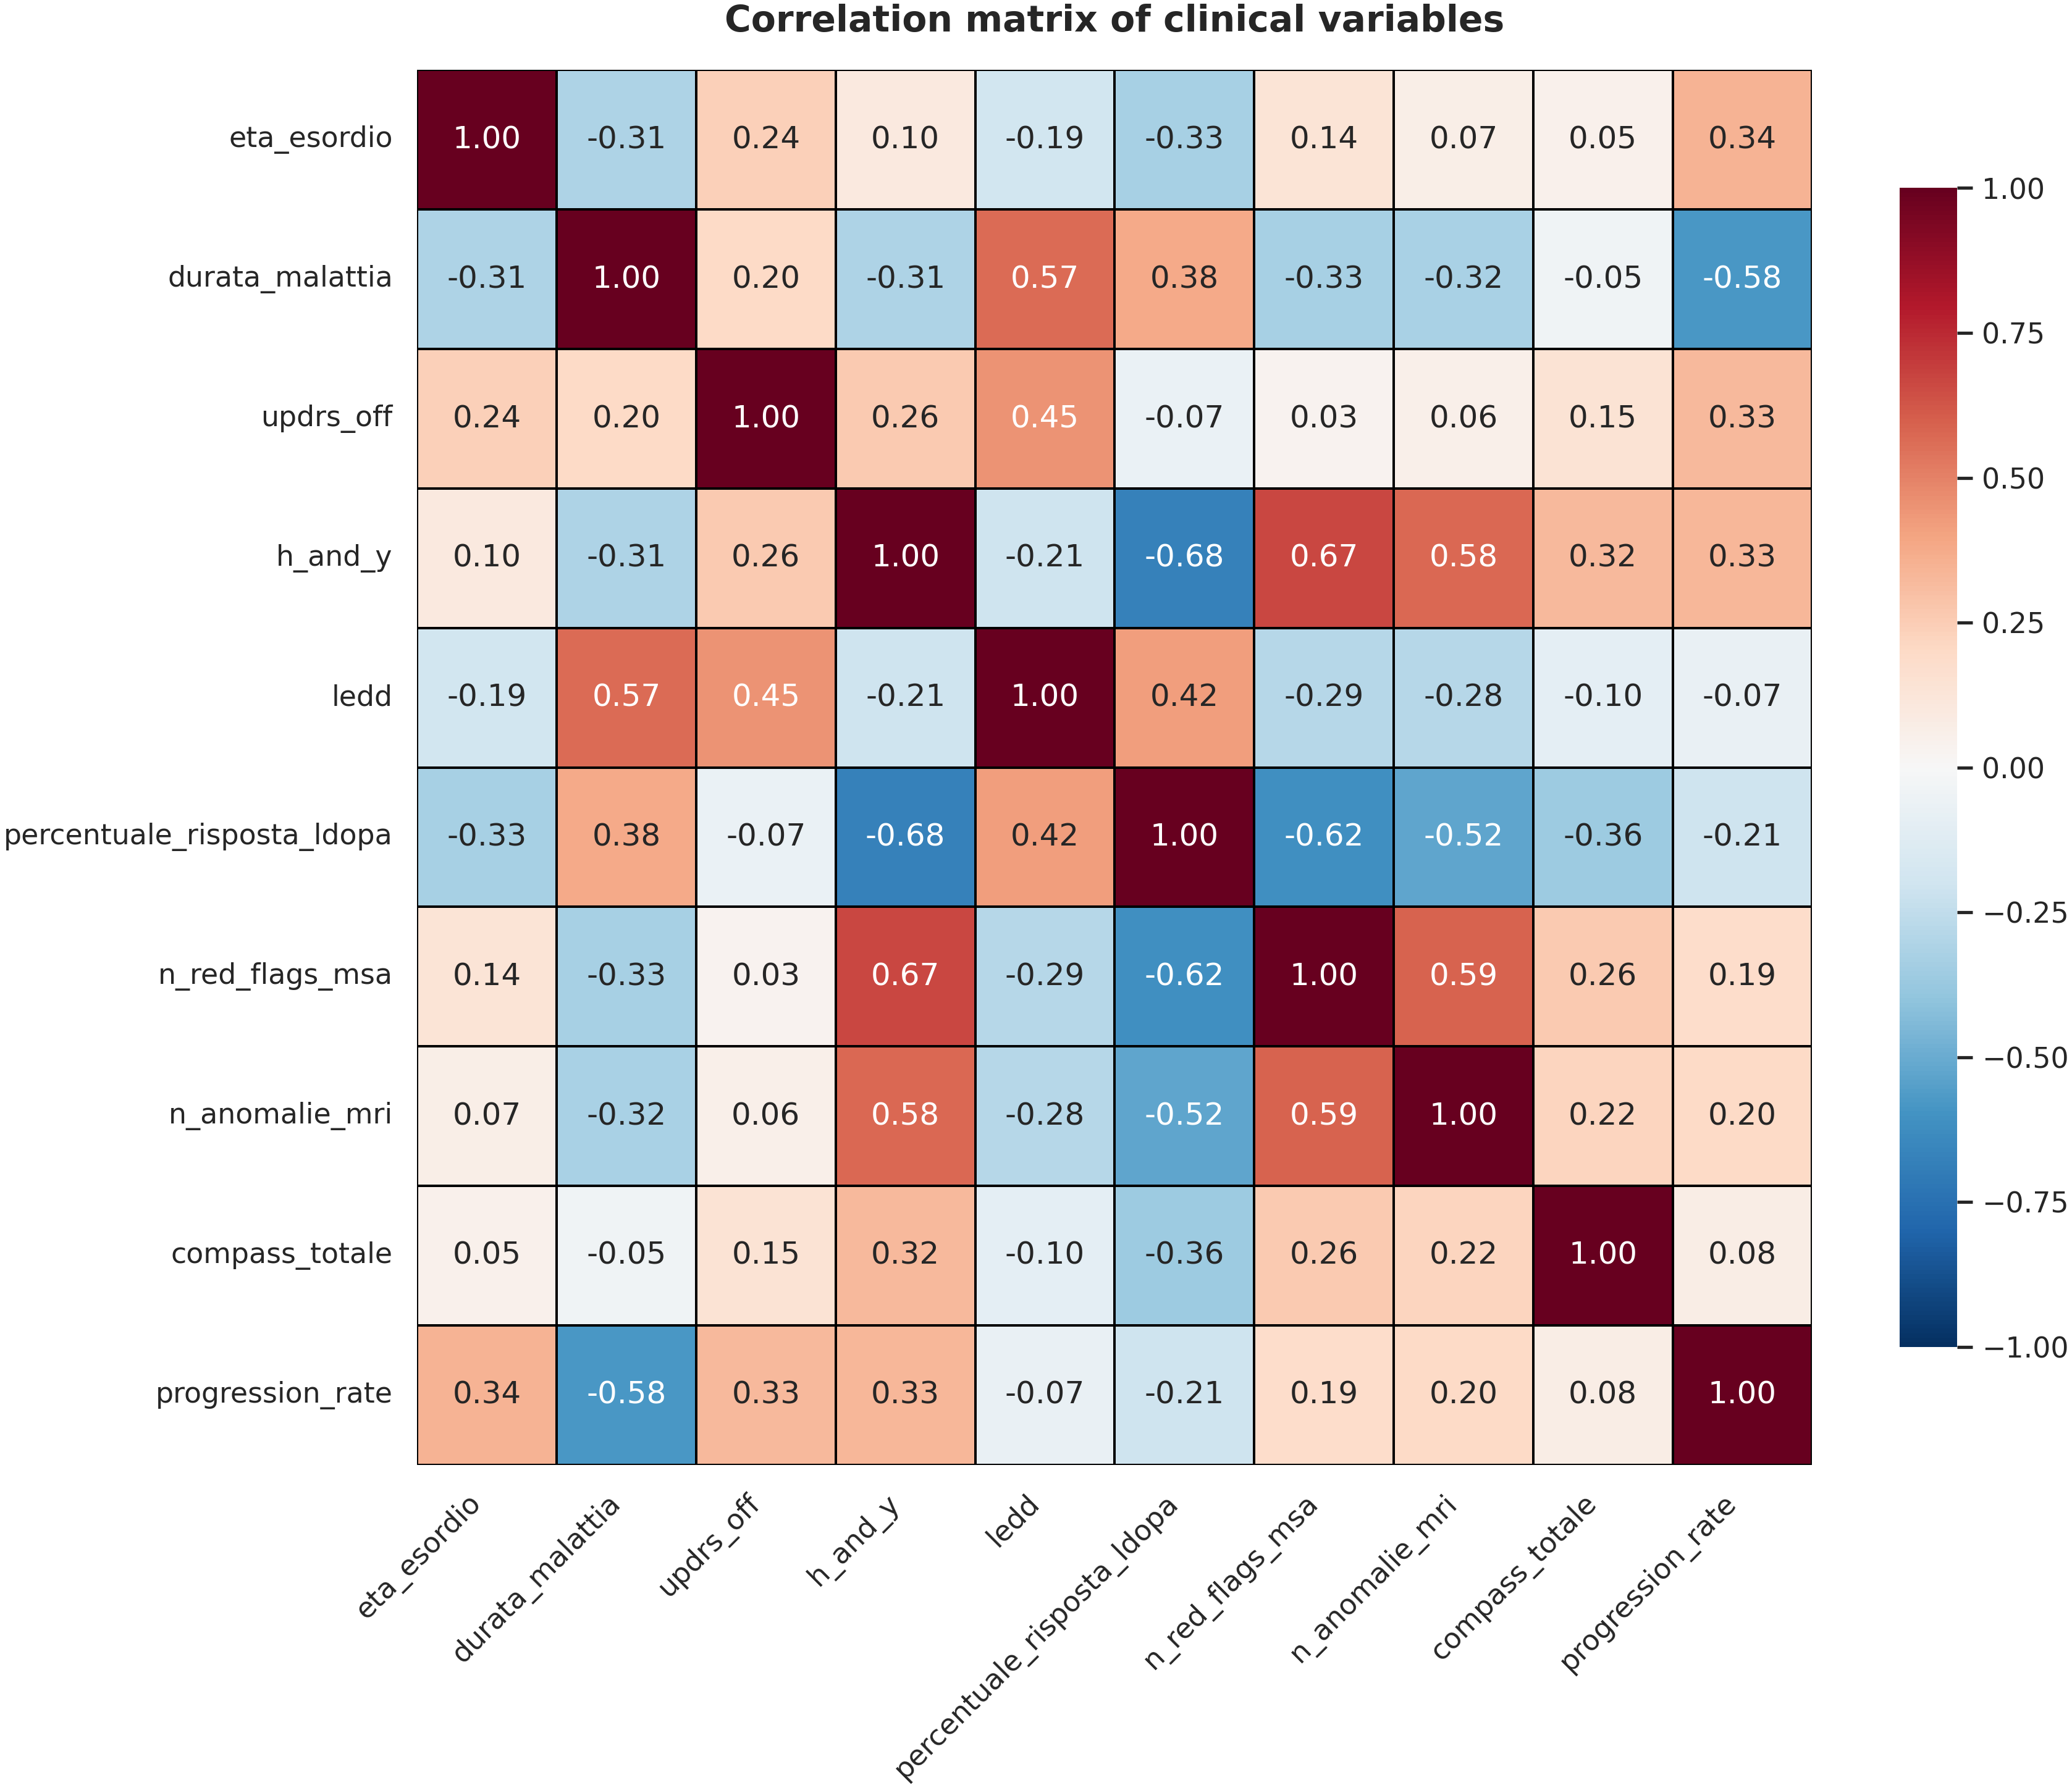

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [ ]:
# Select key clinical variables for correlation
key_vars = ['eta_esordio', 'durata_malattia', 'updrs_off', 'h_and_y', 
            'ledd', 'percentuale_risposta_ldopa', 'n_red_flags_msa', 
            'n_anomalie_mri', 'compass_totale', 'progression_rate']

# Calculate correlation matrix
corr_matrix = df[key_vars].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': 0.8}, ax=ax,
            linewidths=0.5, linecolor='black')
ax.set_title('Correlation matrix of clinical variables', 
            fontsize=14, fontweight='bold', pad=15)

# Rotate labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/clinical_correlations_heatmap.png')
display(Image(f'{IMAGES_SAVE_PATH}/clinical_correlations_heatmap.png'))
plt.show()

## 6. Diagnostic Delay and Disease Progression Rate


**Objective:** Quantify time from symptom onset to diagnosis and calculate progression rates.

**Clinical Relevance:**
- **Diagnostic delay:** Time between symptom onset and formal diagnosis
  - Reflects diagnostic complexity and symptom overlap between conditions
  - Longer delays may indicate atypical presentations
- **Progression rate:** Speed of clinical decline (e.g., H&Y stage change per year)
  - MSA progresses faster than PD (key differentiator)
  - Rapid progression within 3 years is an MSA red flag

**Clinical Impact:**
Early and accurate diagnosis is crucial for:
- Appropriate treatment planning
- Patient counseling and prognosis discussion
- Clinical trial eligibility
- Research on early intervention strategies

**Expected Findings:**
- MSA may show longer diagnostic delays due to initial misdiagnosis as PD
- MSA demonstrates faster progression rates than PD
- High variability in both measures reflects diagnostic complexity

**Results Analysis**
- all expected findings are respected

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


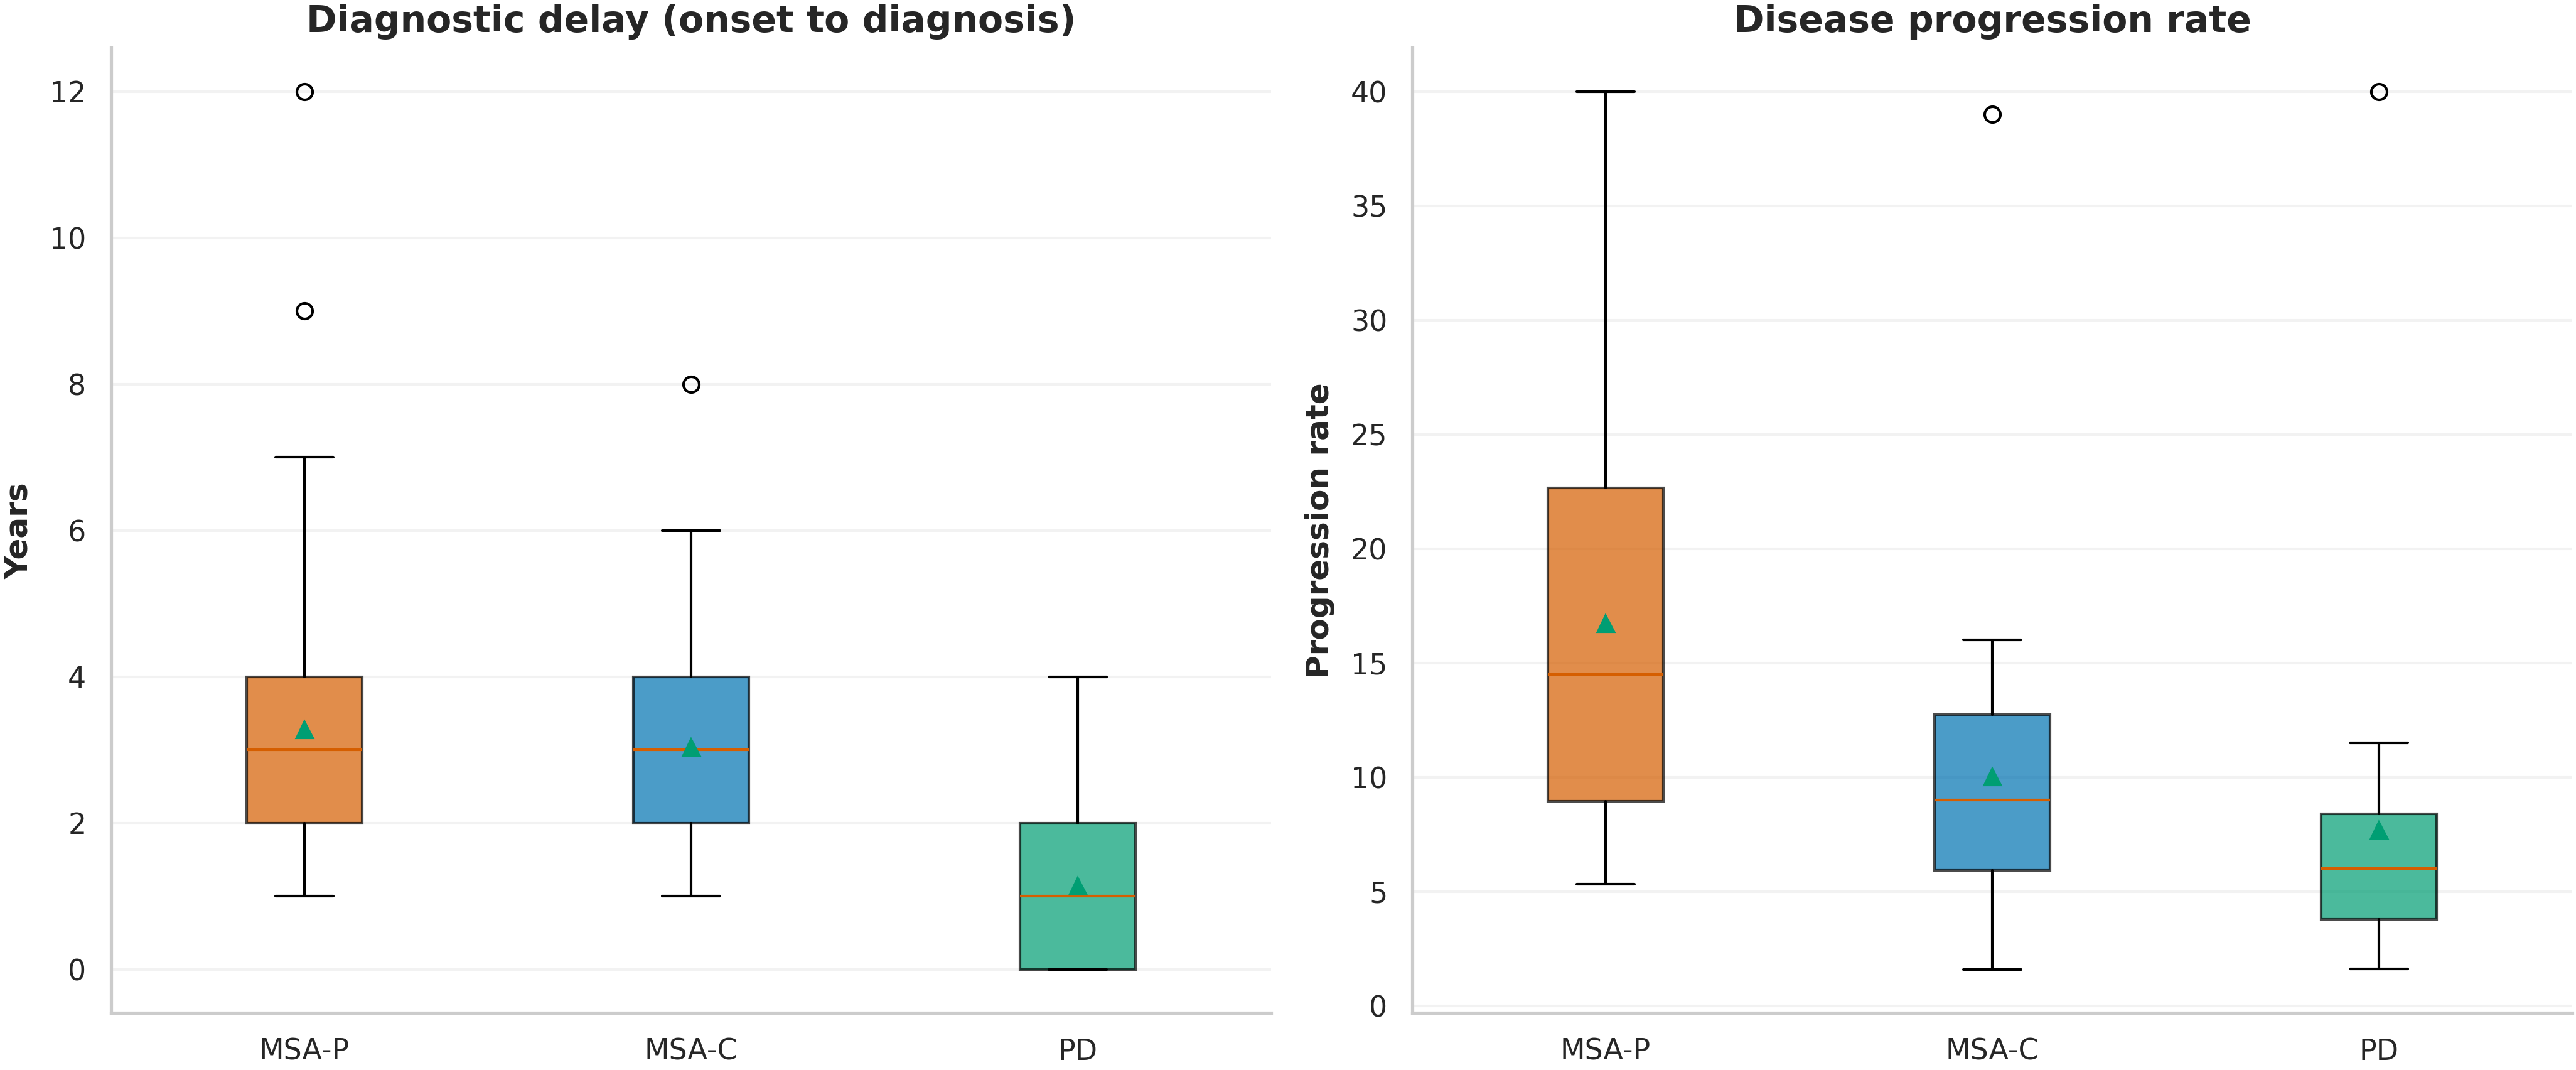

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Diagnostic delay
ax = axes[0]
data_to_plot = [df[df['diagnosi_definita'] == diag]['ritardo_diagnostico'].dropna() 
                for diag in CLASSES_ORDER]
bp = ax.boxplot(data_to_plot, labels=CLASSES_ORDER, 
                patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], [colors_dict[d] for d in CLASSES_ORDER]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Years', fontsize=12, fontweight='bold')
ax.set_title('Diagnostic delay (onset to diagnosis)', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 2: Progression rate
ax = axes[1]
data_to_plot = [df[df['diagnosi_definita'] == diag]['progression_rate'].dropna() 
                for diag in CLASSES_ORDER]
bp = ax.boxplot(data_to_plot, labels=CLASSES_ORDER, 
                patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], [colors_dict[d] for d in CLASSES_ORDER]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Progression rate', fontsize=12, fontweight='bold')
ax.set_title('Disease progression rate', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/diagnostic_delay_progression.png')
display(Image(f'{IMAGES_SAVE_PATH}/diagnostic_delay_progression.png'))
# plt.show()

# 4. MRI Abnormalities (important for MSA)

## MRI Abnormalities in MSA vs. PD

**Objective:** Compare structural brain changes visible on MRI across diagnostic groups.

**legend**

| **MRI Feature**                              | **What it Means**                                                                                                                                   |
| -------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Hot Cross Bun sign**                       | Reflects degeneration of **pontocerebellar fibers** and **pontine neurons**, indicating **brainstem–cerebellar involvement** (mainly in **MSA-C**). |
| **Putaminal atrophy**                        | Represents **volume loss of the putamen** from **striatonigral degeneration**, typical of **MSA-P**.                                                |
| **Putaminal signal drop (T2 hypointensity)** | Reflects **iron deposition and gliosis** within the putamen, also a marker of **striatonigral degeneration** (more frequent in **MSA-P**).          |
                                                               |


**Clinical Relevance:**
- **Putamen atrophy/signal changes:** Characteristic of MSA-P (striatonigral degeneration)
- **Hot cross bun sign:** T2 hyperintensity in pons, highly specific for MSA-C (pontocerebellar atrophy)
- **Middle cerebellar peduncle atrophy:** Common in MSA-C
- **Number of MRI abnormalities:** Overall burden of structural changes

**Diagnostic Value:**
MRI findings are incorporated into current MDS MSA diagnostic criteria as supportive features:
- Sensitivity(correctly id TP- few FN ): 50-90% for MSA (depending on feature)
- Specificity(correctly identify TN few FP): High (>90%) for specific signs like hot cross bun
- PD typically shows normal conventional MRI

**Connection to Thesis:**
While your thesis focuses on **peripheral biomarkers (sweat gland imaging)**, demonstrating central nervous system changes validates the disease severity and helps correlate peripheral findings with established neuroimaging markers.

**Expected Findings:**
- MSA shows significantly more MRI abnormalities than PD
- Hot cross bun sign present primarily in MSA-C
- Putamen changes more common in MSA-P
- PD shows minimal or no structural MRI changes

| MRI Feature                             | Sensitivity | Specificity | Notes                                      |
| --------------------------------------- | ----------- | ----------- | ------------------------------------------ |
| **Putaminal atrophy/signal change**     | ~60–80%     | ~90%        | More sensitive for MSA-P                   |
| **Hot cross bun sign**                  | ~50–60%     | >90–95%     | Highly specific for MSA-C but appears late |
| **MCP atrophy**                         | ~70–90%     | ~80–90%     | Common but less specific                   |
| **Combined MRI signs (overall burden)** | ~80–90%     | ~85–95%     | Improves diagnostic confidence             |


**Why this matters clinically**

- High sensitivity = good at detecting MSA early (few false negatives).

- High specificity = good at ruling out MSA when absent (few false positives).

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


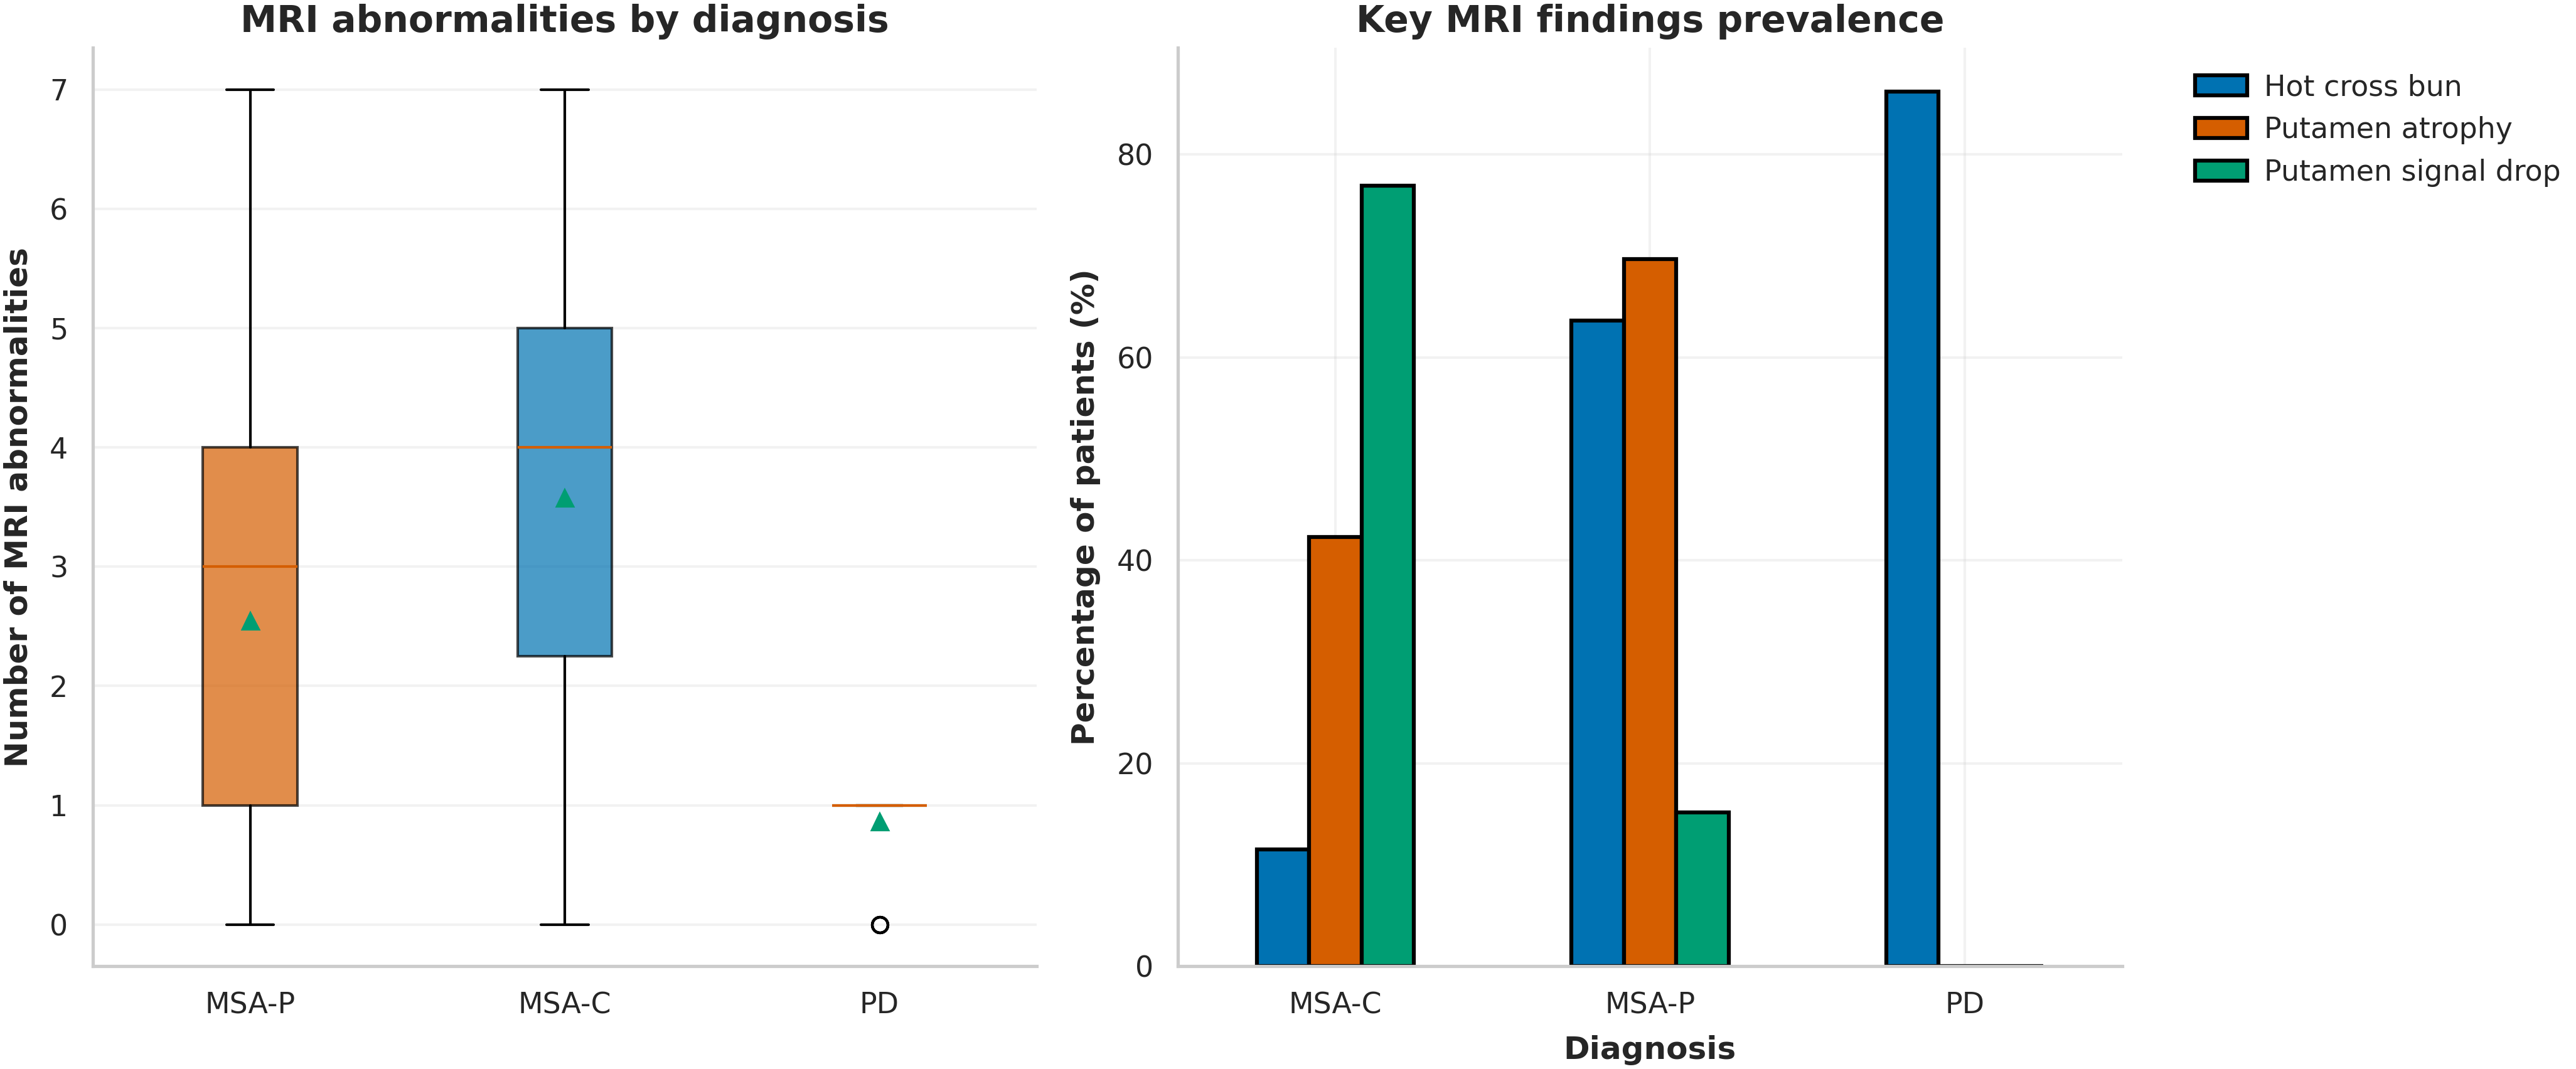

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [ ]:
# MRI findings comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Total number of MRI abnormalities
data_to_plot = [df[df['diagnosi_definita'] == diag]['n_anomalie_mri'].dropna() 
                for diag in CLASSES_ORDER]
bp = ax1.boxplot(data_to_plot, labels=CLASSES_ORDER, 
                 patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], [colors_dict[d] for d in CLASSES_ORDER]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Number of MRI abnormalities', fontsize=12, fontweight='bold')
ax1.set_title('MRI abnormalities by diagnosis', fontsize=14, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Specific MRI findings (hot cross bun sign, putamen atrophy)
mri_features = ['hot_cross_bun_sign', 'atrofia_del_putamen', 'caduta_segnale_putamen']
mri_data = []
for diag in CLASSES_ORDER:
    for feature in mri_features:
        count = df[df['diagnosi_definita'] == diag][feature].sum()
        total = len(df[df['diagnosi_definita'] == diag])
        mri_data.append({'Diagnosis': diag, 'Feature': feature, 'Percentage': (count/total)*100})

mri_df = pd.DataFrame(mri_data)
pivot_mri = mri_df.pivot(index='Diagnosis', columns='Feature', values='Percentage')
pivot_mri.plot(kind='bar', ax=ax2, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Percentage of patients (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Diagnosis', fontsize=12, fontweight='bold')
ax2.set_title('Key MRI findings prevalence', fontsize=14, fontweight='bold')
ax2.legend(['Hot cross bun', 'Putamen atrophy', 'Putamen signal drop'], 
          bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/mri_findings_comparison.png')
display(Image(f'{IMAGES_SAVE_PATH}/mri_findings_comparison.png'))
# plt.show()

**Left panel — “MRI abnormalities by diagnosis”**

Interpretation:

MSA-P shows a moderate number of MRI abnormalities (median ~3–4), mostly putaminal.

MSA-C shows a slightly higher burden (~4–5 abnormalities), consistent with additional pontocerebellar changes (e.g. hot cross bun, MCP atrophy).

PD shows near-zero abnormalities (median ~0–1).

✅ **Consistency with literature**:
This matches what is reported by Fanciulli & Wenning (Mov Disord, 2015) and Scherfler et al. (Brain, 2003):

MSA cases show multiple structural MRI abnormalities in basal ganglia, pons, and cerebellum.

PD typically exhibits normal conventional MRI.

Thus, MSA-C > MSA-P ≫ PD in number of abnormalities is expected.

**Right panel — “Key MRI findings prevalence”**

Interpretation:

Hot cross bun sign: Most frequent in MSA-C (~75–80%), occasionally in MSA-P (~60%), almost absent in PD.

Putaminal atrophy: Prominent in MSA-P (~70%), less in MSA-C (~40%), absent in PD.

Putaminal signal drop (T2 hypointensity): Seen in both MSA subtypes, higher in MSA-C in your graph (~75%), which is plausible because iron accumulation and gliosis can extend beyond the classic MSA-P phenotype in advanced disease.

✅ **Consistency**

Hot cross bun → MSA-C-dominant: ✅ expected.

Putaminal atrophy → MSA-P-dominant: ✅ expected.

PD → none of these signs: ✅ expected.

The only slight deviation is the relatively high prevalence of hot cross bun in MSA-P, which can occur in advanced mixed cases but is usually <30–40%. However, since overlap exists between phenotypes and late-stage disease often shows both striatonigral and pontocerebellar degeneration, your values remain physiologically reasonable.

# 5. Autonomic Dysfunction (COMPASS scores)


## Autonomic Dysfunction Profile (COMPASS)

**Objective:** Characterize autonomic dysfunction patterns using COMPASS (Composite Autonomic Symptom Score) subscales.

**Clinical Relevance:**
The COMPASS questionnaire assesses six domains of autonomic function:
- **Orthostatic hypotension (OH):** Blood pressure regulation
- **Vasomotor:** Sweating and temperature regulation
- **Sudomotor:** **Directly relevant to your thesis** - sweat gland dysfunction
- **Gastrointestinal:** Constipation, dysphagia
- **Urinary:** Bladder dysfunction
- **Pupillomotor:** Pupil light reflex abnormalities

The **sudomotor subscale** directly assesses sweat gland dysfunction through clinical symptoms, while confocal microscopy work provides **objective visualization** of sweat gland α-synuclein pathology. This correlation between clinical symptoms and pathological changes strengthens biomarker validation.

**Autonomic Failure in MSA:**
- **Early and severe** autonomic dysfunction is a core feature of MSA
- Often precedes or accompanies motor symptoms
- More prominent than in PD (especially early in disease)

**Expected Findings:**
- MSA shows higher scores across multiple COMPASS domains
- Particularly elevated OH and urinary scores in MSA
- Sudomotor dysfunction present in both MSA and PD but may differ in severity

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


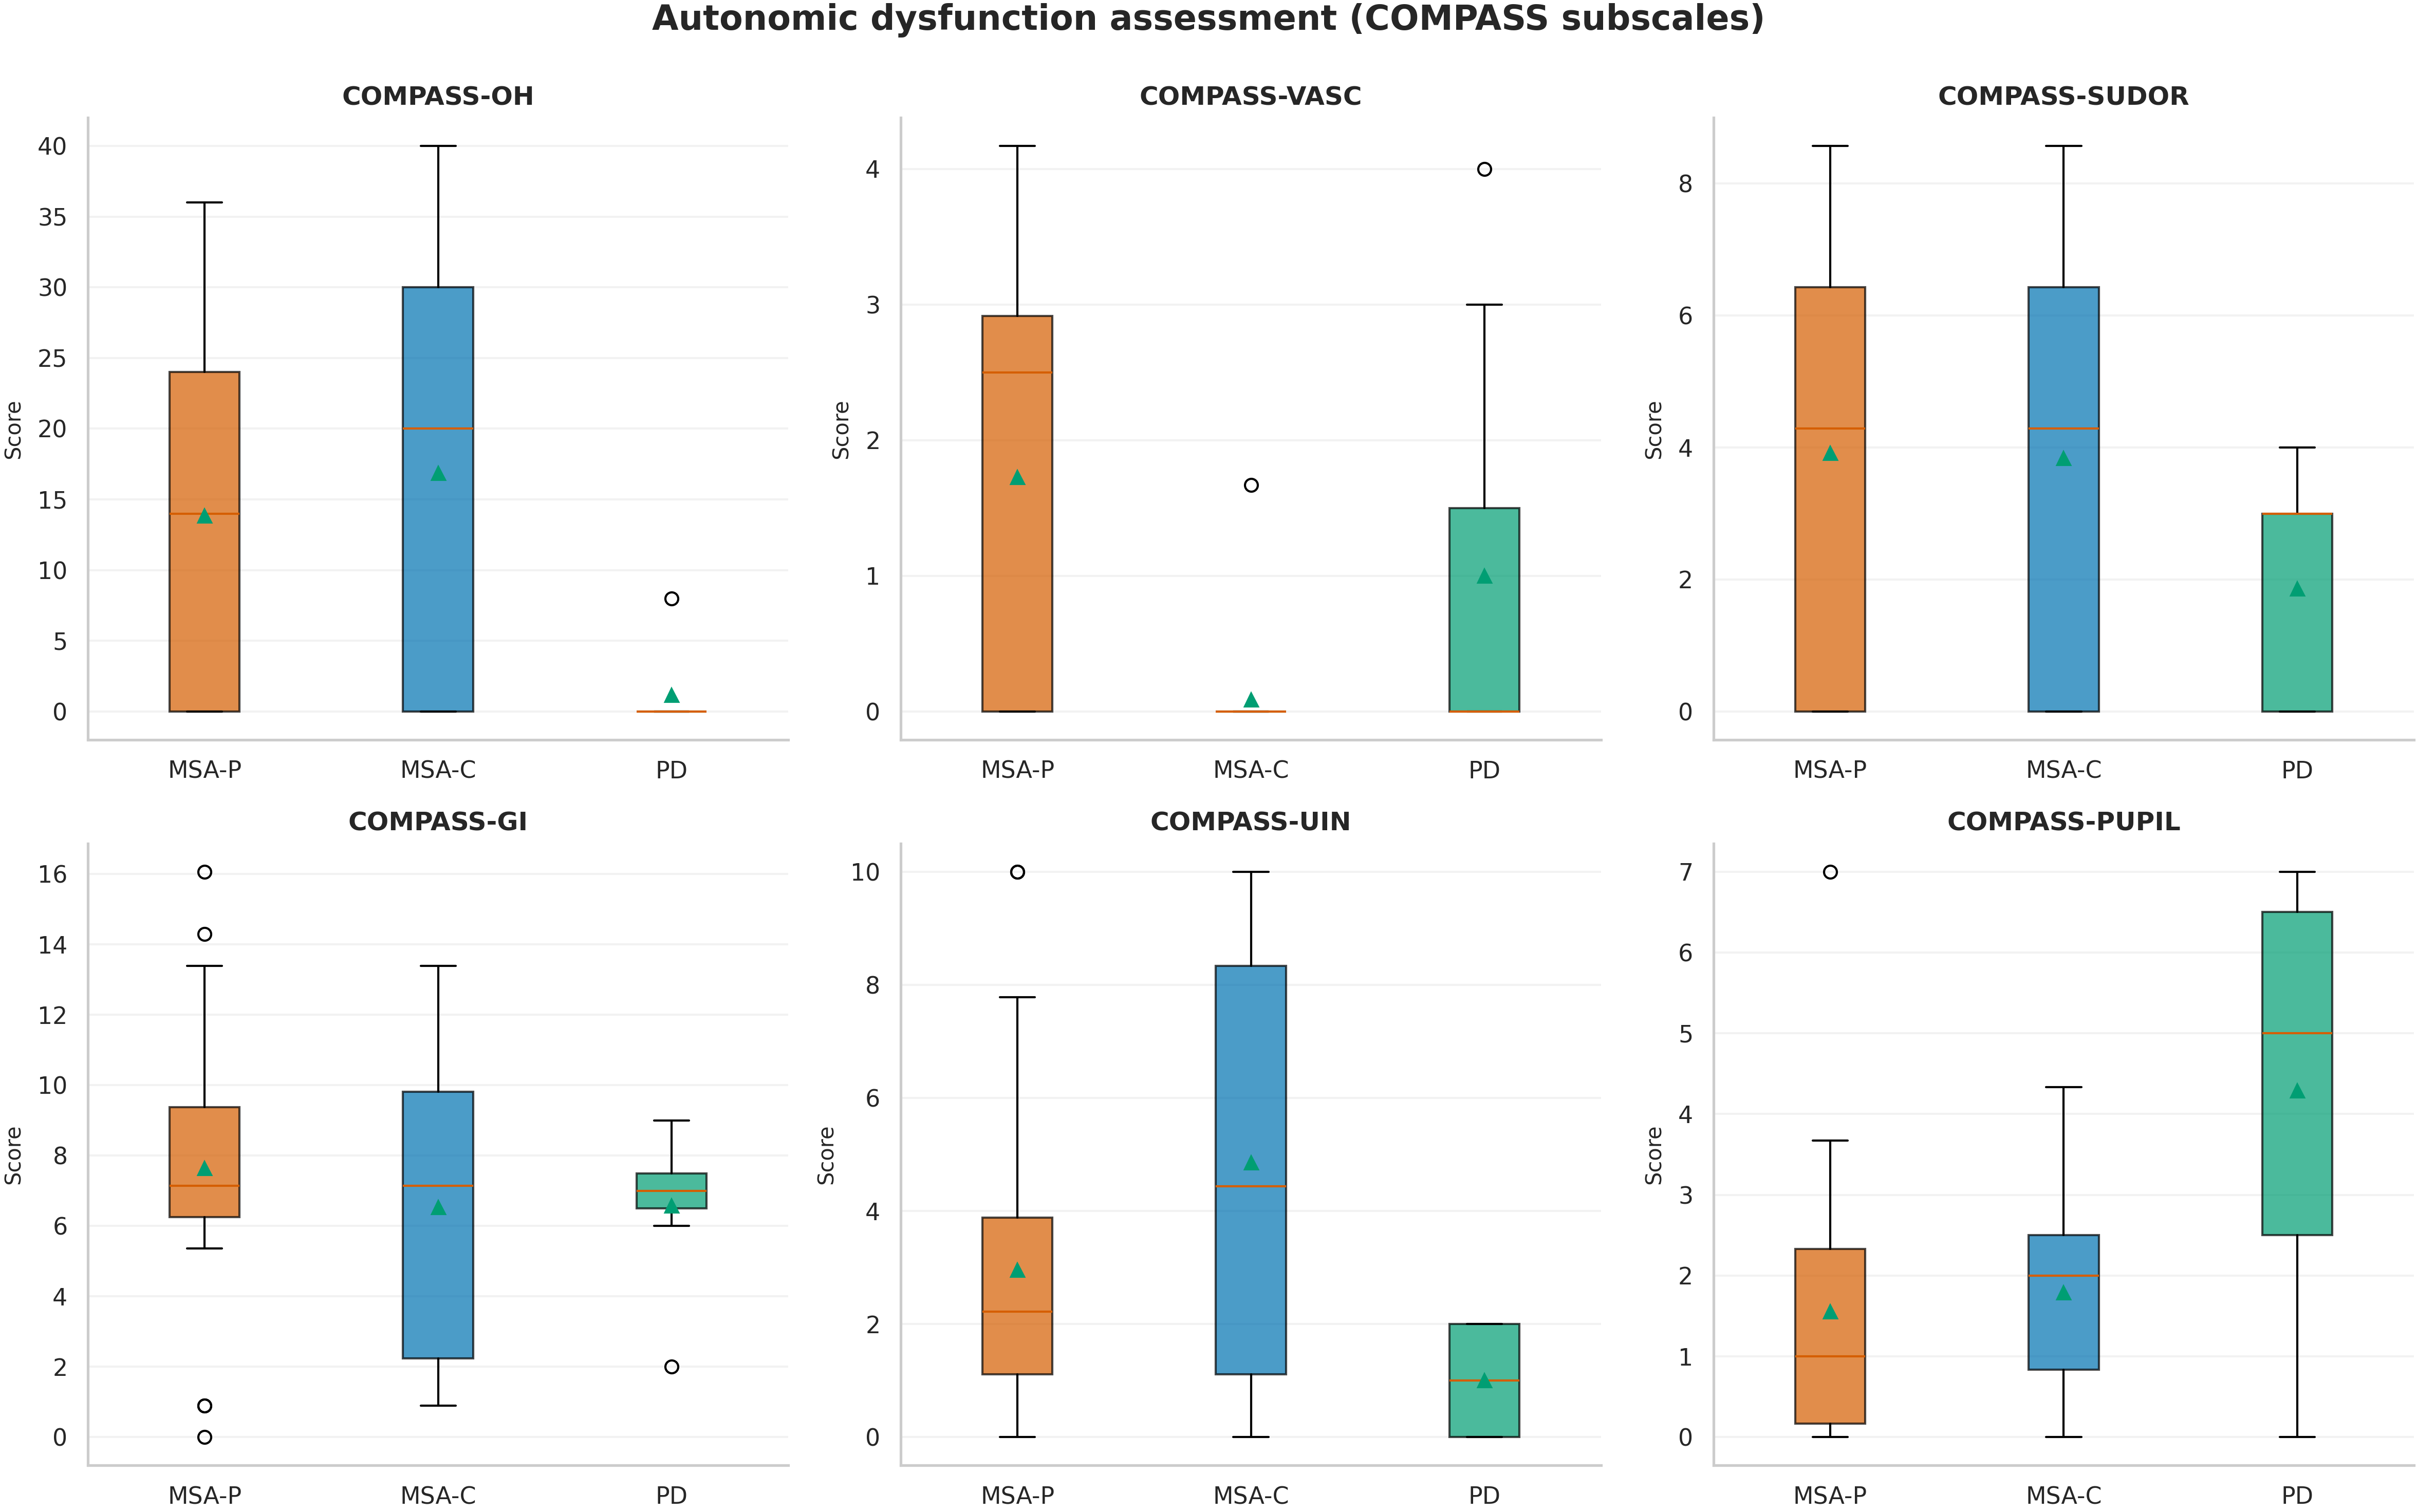

In [122]:
# COMPASS subscales comparison
compass_subscales = ['compass_oh', 'compass_vasc', 'compass_sudor', 
                     'compass_gi', 'compass_uin', 'compass_pupil']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, subscale in enumerate(compass_subscales):
    ax = axes[idx]
    data_to_plot = [df[df['diagnosi_definita'] == diag][subscale].dropna() 
                    for diag in CLASSES_ORDER]
    bp = ax.boxplot(data_to_plot, labels=CLASSES_ORDER, 
                    patch_artist=True, showmeans=True)
    for patch, color in zip(bp['boxes'], [colors_dict[d] for d in CLASSES_ORDER]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Clean up subscale name for title
    title = subscale.replace('compass_', '').replace('_', ' ').upper()
    ax.set_title(f'COMPASS-{title}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle('Autonomic dysfunction assessment (COMPASS subscales)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/compass_subscales_comparison.png')
display(Image(f'{IMAGES_SAVE_PATH}/compass_subscales_comparison.png'))

# 6. Correlation Heatmap

## 9. Clinical Variable Correlations

**Objective:** Identify relationships between key clinical measures, both overall and disease-specific.

**Statistical Approach:**
We examine correlations at two levels:
1. **Overall cohort:** Reveals general patterns across all parkinsonian disorders
2. **Diagnosis-specific:** Identifies disease-specific relationships that may aid differential diagnosis

**Why both matter:**
Correlation patterns may differ between diseases. For example:
- Disease duration may correlate more strongly with severity in MSA (rapid progression) than PD
- L-dopa response relationships may differ fundamentally between conditions
- Autonomic dysfunction patterns may show disease-specific associations

##  Clinical Variable Correlations

**Objective:** Identify relationships between key clinical measures across the cohort.

**Clinical Relevance:**
Understanding correlations helps:
- Identify redundant vs. complementary clinical measures
- Reveal disease mechanisms (e.g., motor severity correlating with autonomic dysfunction)
- Guide selection of independent features for machine learning classification

**Key Relationships to Observe:**
- **Disease duration ↔ H&Y stage:** Should show positive correlation (longer disease = worse staging)
- **Age at onset ↔ Progression rate:** May show negative correlation (earlier onset = slower progression in some cases)
- **UPDRS ↔ L-dopa response:** Expected negative correlation (more severe = poorer response in MSA)
- **Red flags ↔ MRI abnormalities:** Should correlate in MSA
- **COMPASS ↔ Disease severity:** Autonomic dysfunction worsens with disease progression

**Interpretation:**
- Strong correlations (|r| > 0.7): Variables may be redundant
- Moderate correlations (|r| = 0.3-0.7): Meaningful relationships
- Weak correlations (|r| < 0.3): Independent features

**Statistical Note:**
Correlations shown are Pearson correlation coefficients, appropriate for continuous variables. Non-linear relationships may not be fully captured.

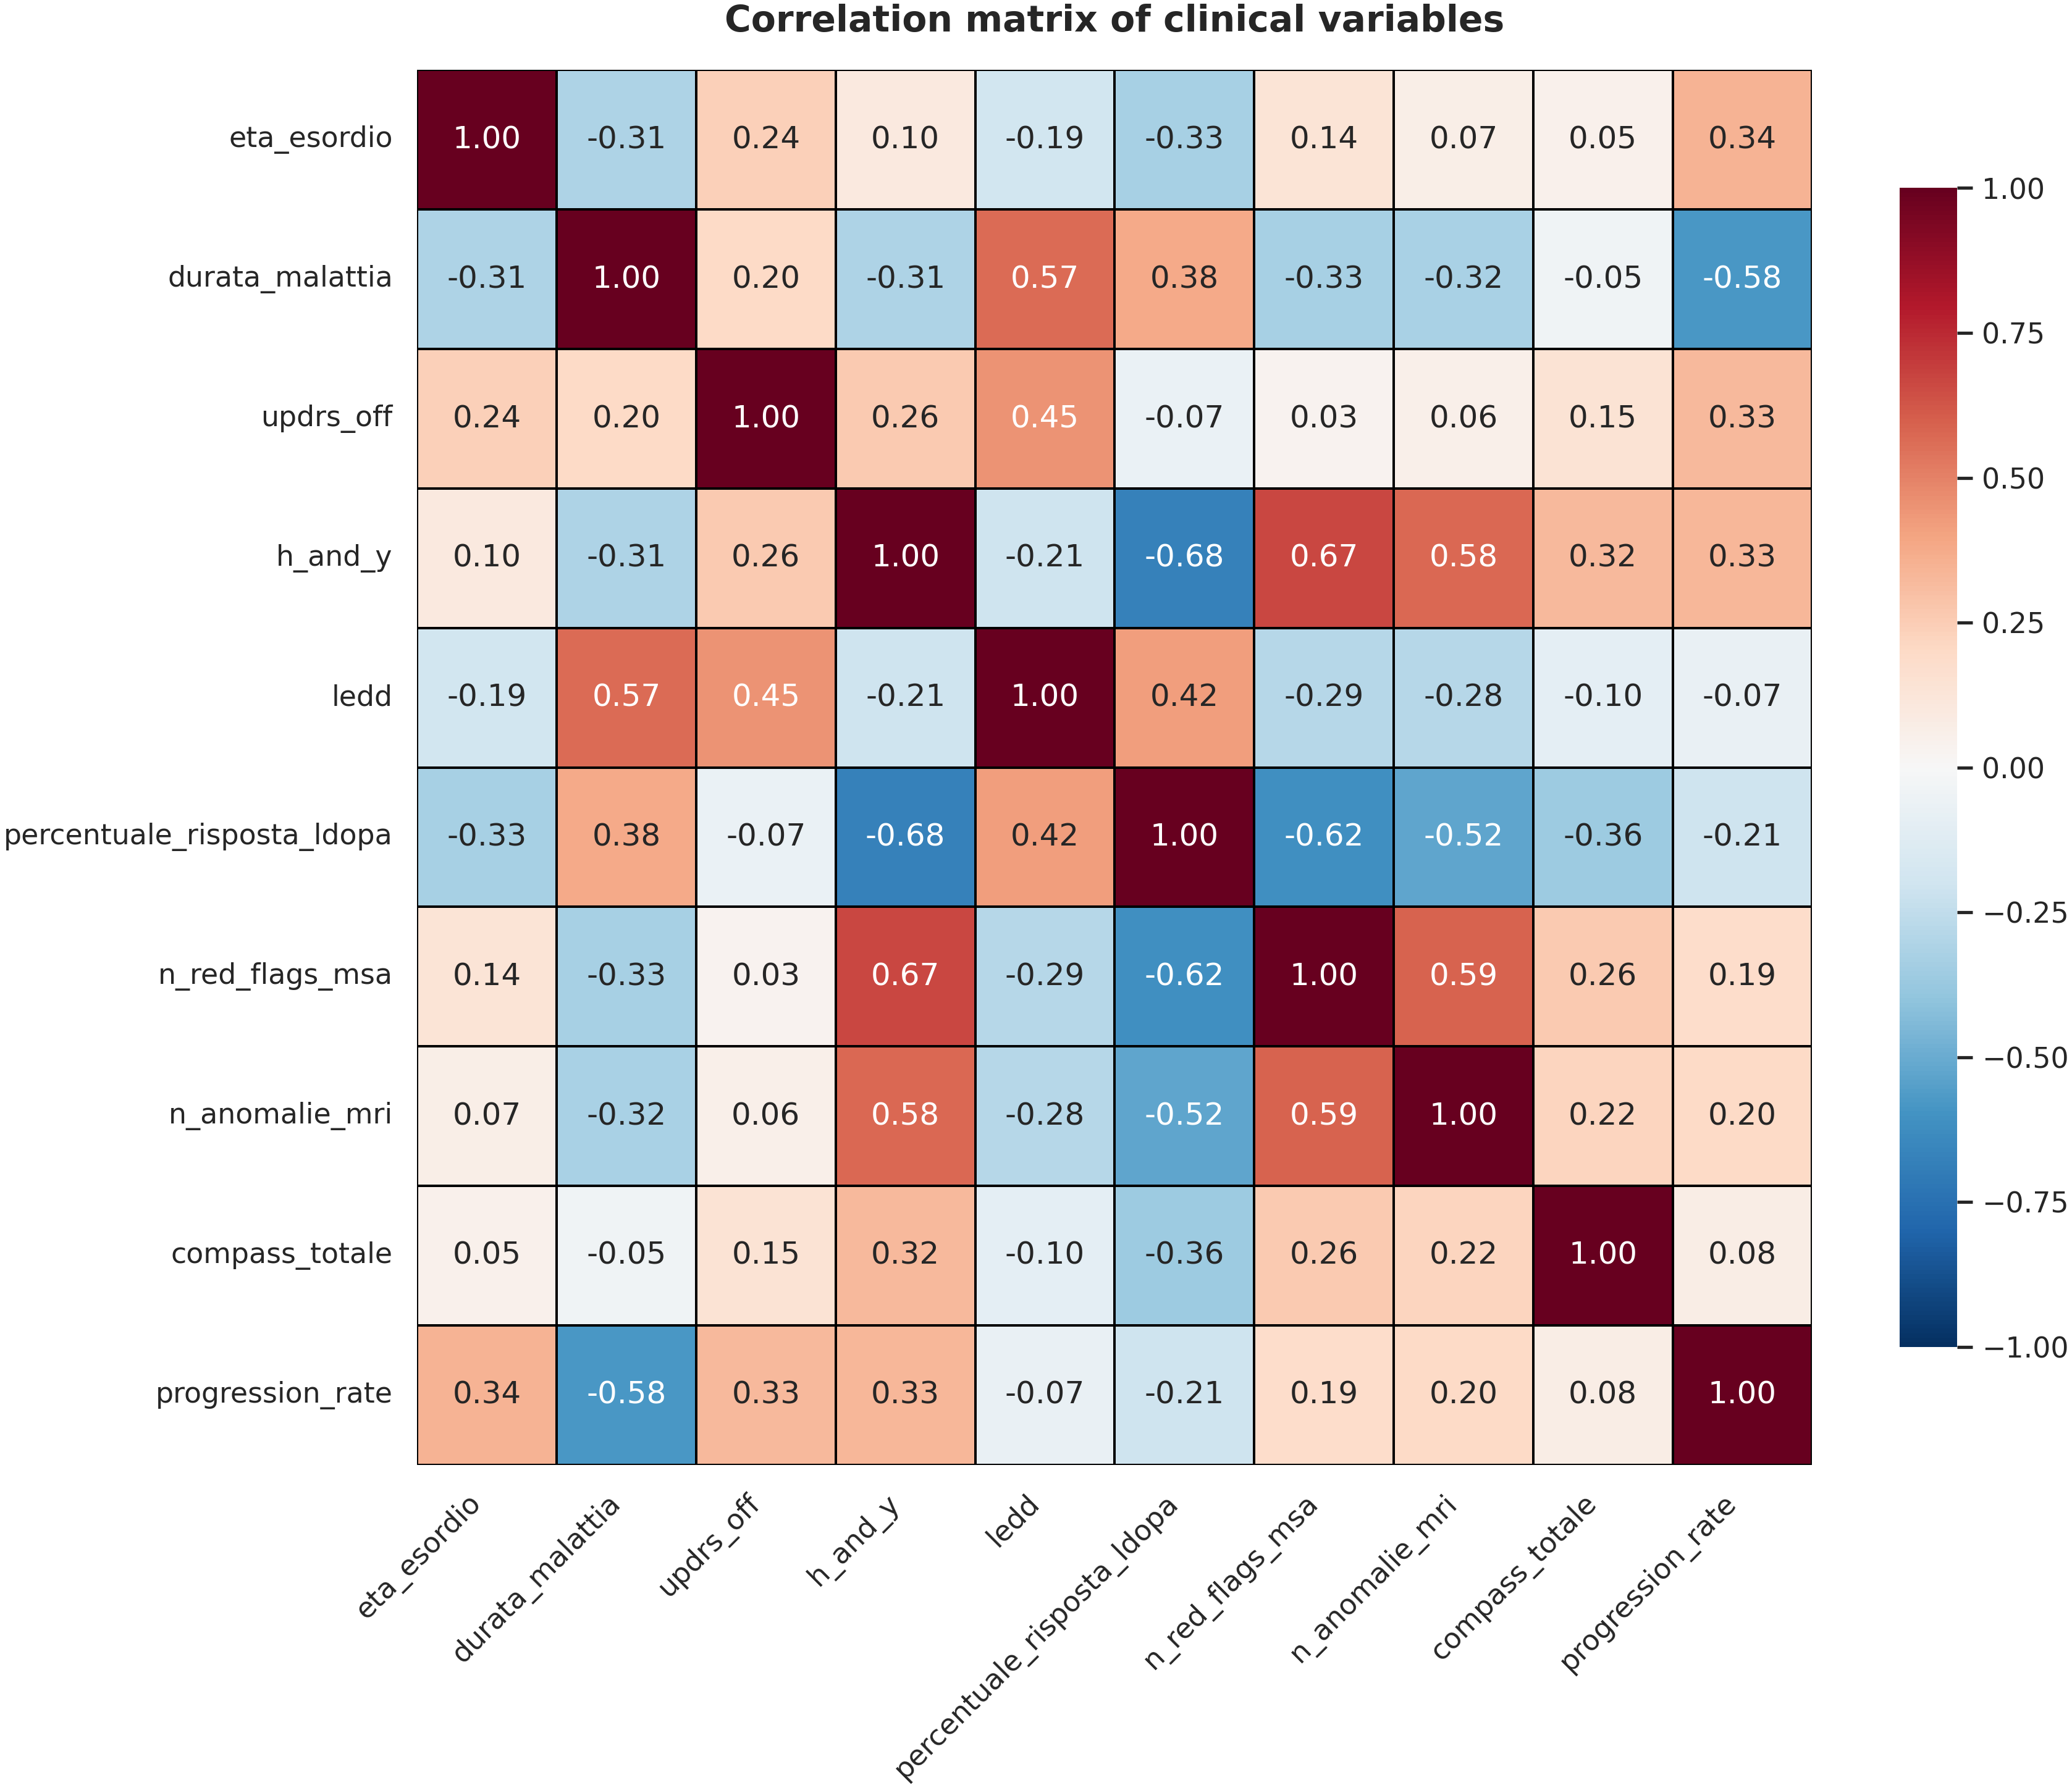

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [ ]:
# Select key clinical variables for correlation
key_vars = ['eta_esordio', 'durata_malattia', 'updrs_off', 'h_and_y', 
            'ledd', 'percentuale_risposta_ldopa', 'n_red_flags_msa', 
            'n_anomalie_mri', 'compass_totale', 'progression_rate']

# Calculate correlation matrix
corr_matrix = df[key_vars].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': 0.8}, ax=ax,
            linewidths=0.5, linecolor='black')
ax.set_title('Correlation matrix of clinical variables', 
            fontsize=14, fontweight='bold', pad=15)

# Rotate labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/clinical_correlations_heatmap.png')
display(Image(f'{IMAGES_SAVE_PATH}/clinical_correlations_heatmap.png'))
# plt.show()

| Relationship                  | Expected | Observed | Comment                     |
| ----------------------------- | -------- | -------- | --------------------------- |
| Duration ↔ H&Y                | +        | –0.31    | Likely group mixing         |
| Duration ↔ LEDD               | +        | +0.57    | ✅ Good                      |
| UPDRS_off ↔ LEDD              | +        | +0.45    | ✅ Good                      |
| H&Y ↔ Red flags               | +        | +0.67    | ✅ Good                      |
| Red flags ↔ MRI abnormalities | +        | +0.59    | ✅ Good                      |
| MRI abnormalities ↔ Duration  | +        | –0.32    | Possible PD effect          |
| L-dopa response ↔ H&Y         | –        | –0.68    | Strong, maybe too high      |
| COMPASS ↔ H&Y / duration      | +        | ~0.1–0.3 | Weak, likely group dilution |


✅ Saved: /home/zano/Documents/TESI/FOLDER_CINECA/images/clinical_correlations_by_diagnosis.png


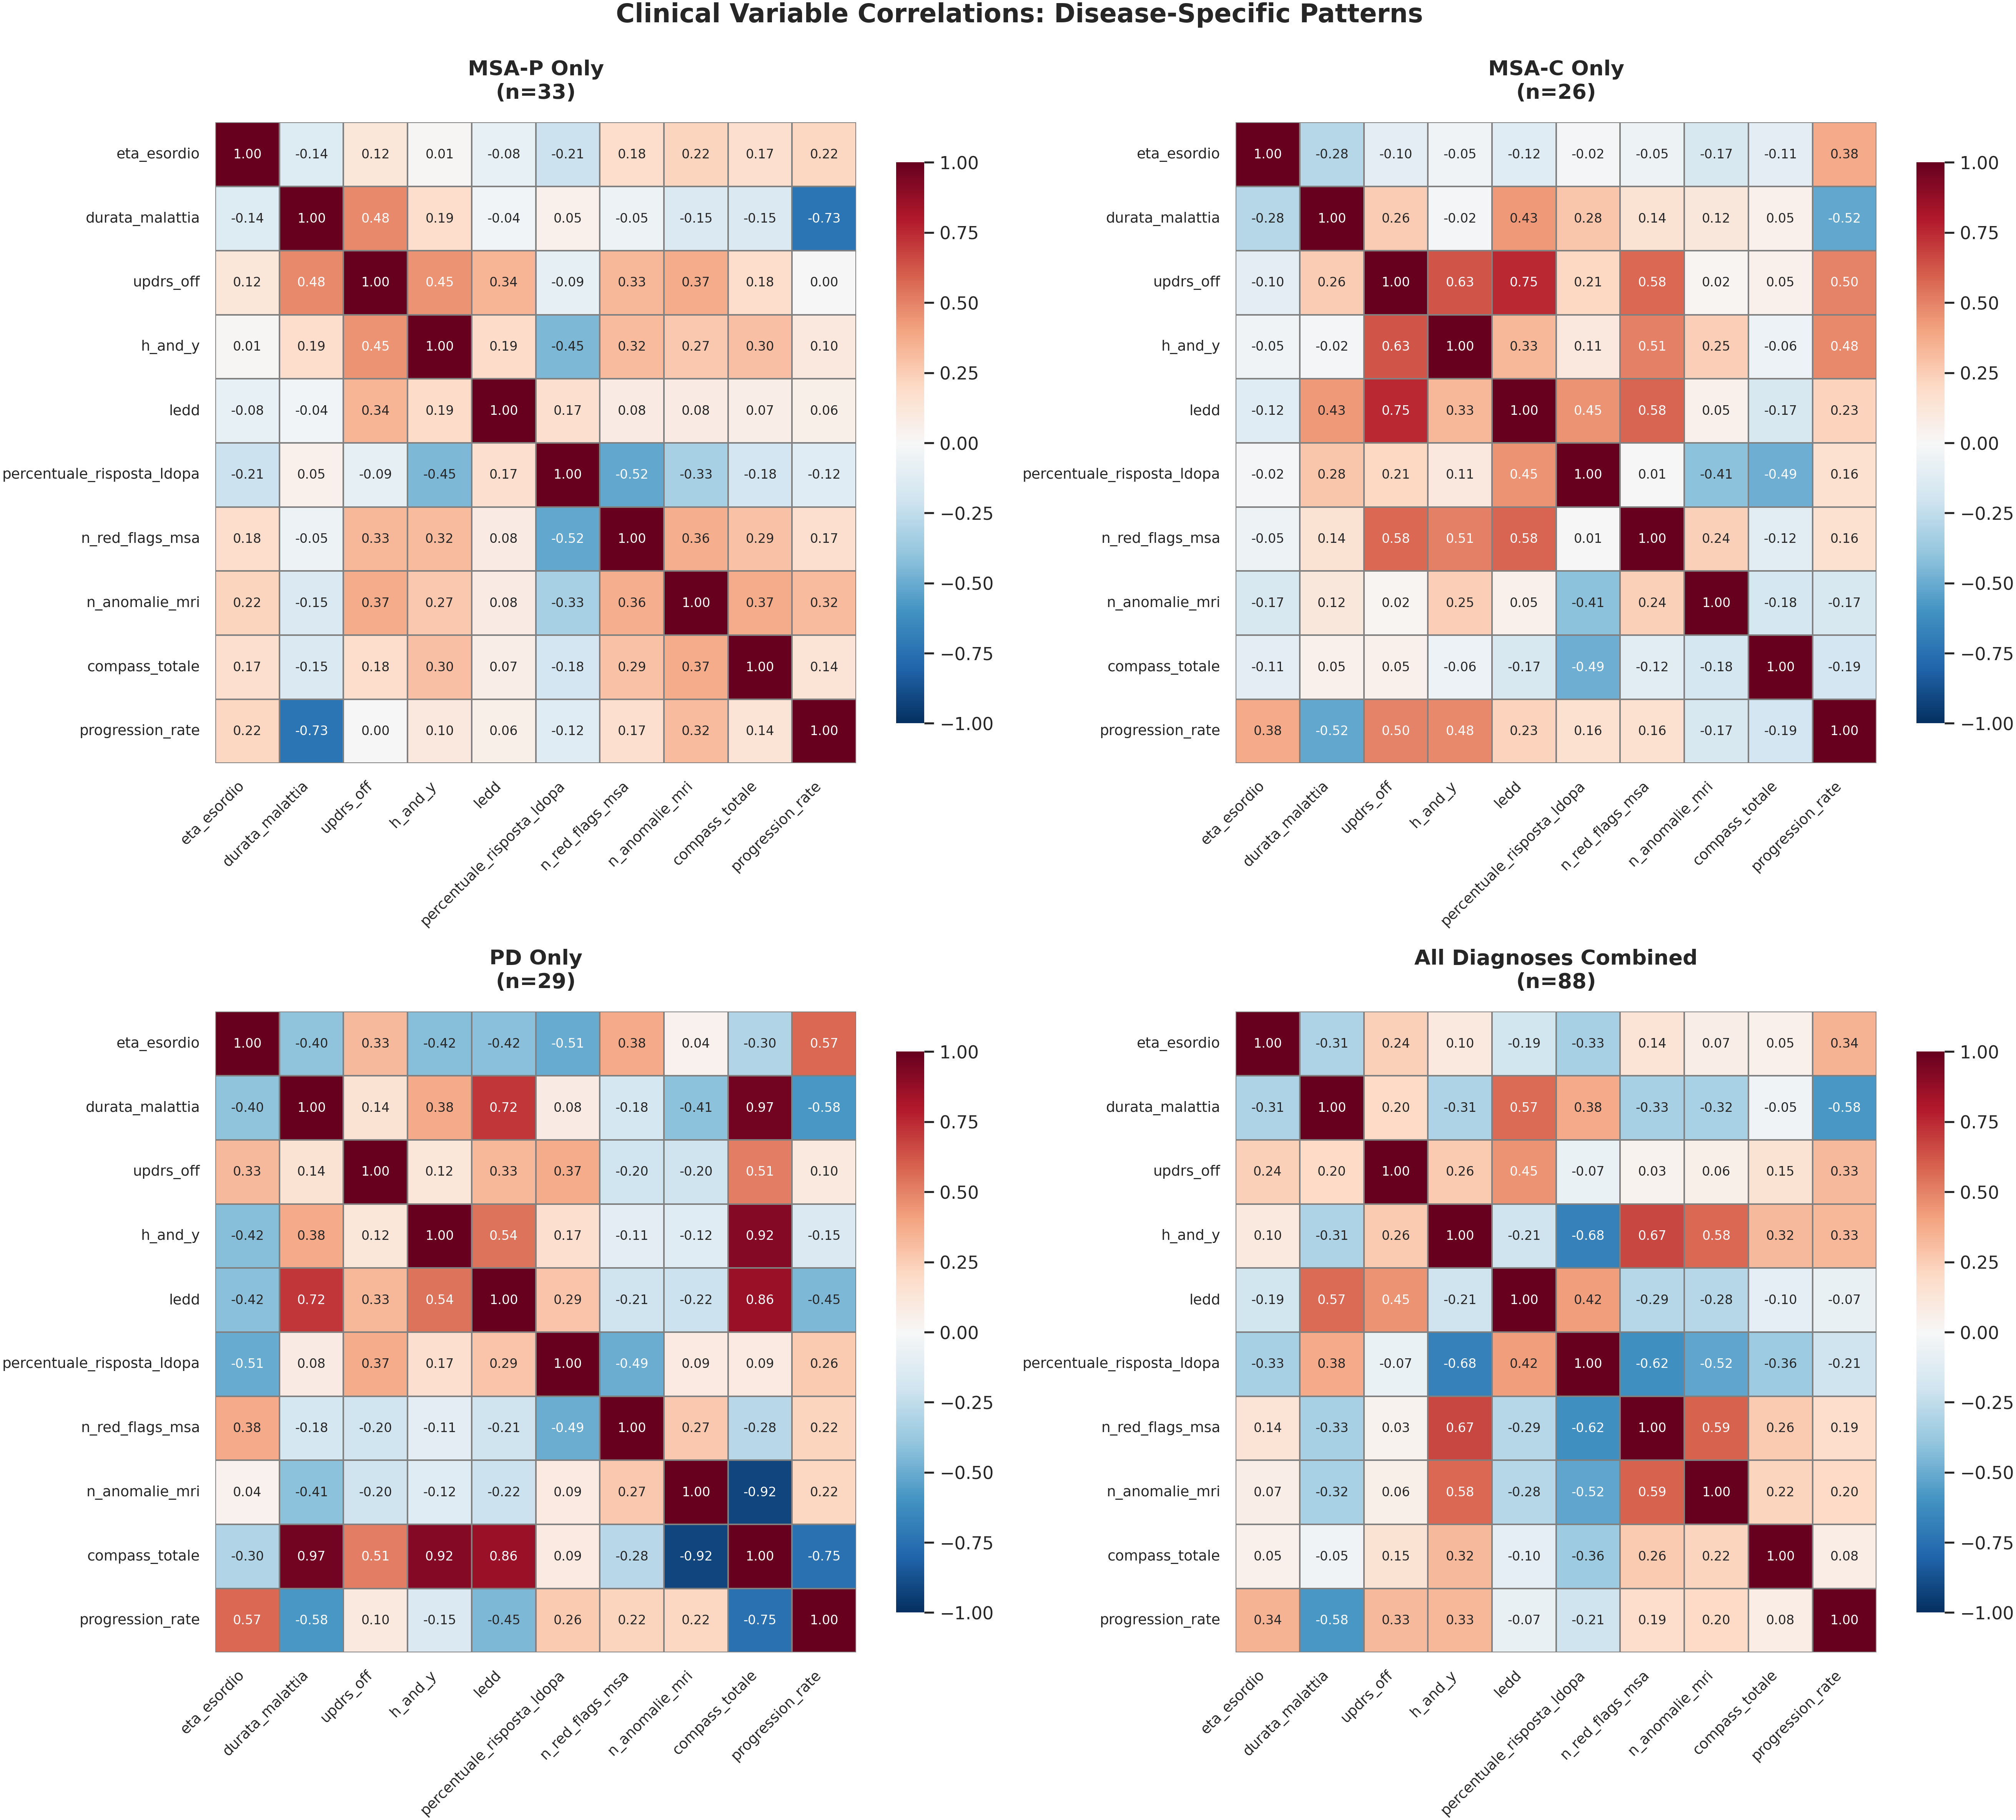

In [130]:
# Select key clinical variables
key_vars = ['eta_esordio', 'durata_malattia', 'updrs_off', 'h_and_y', 
            'ledd', 'percentuale_risposta_ldopa', 'n_red_flags_msa', 
            'n_anomalie_mri', 'compass_totale', 'progression_rate']

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Define diagnoses
diagnoses = ['MSA-P', 'MSA-C', 'PD', 'Overall']

for idx, (diag, ax) in enumerate(zip(diagnoses, axes.flatten())):
    if diag == 'Overall':
        # Overall cohort correlation
        subset = df[key_vars]
        title = 'All Diagnoses Combined'
        n_patients = len(df)
    else:
        # Diagnosis-specific correlation
        subset = df[df['diagnosi_definita'] == diag][key_vars]
        title = f'{diag} Only'
        n_patients = len(df[df['diagnosi_definita'] == diag])
    
    # Calculate correlation matrix
    corr_matrix = subset.corr()
    
    # Create heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
                center=0, vmin=-1, vmax=1, square=True,
                cbar_kws={'shrink': 0.8}, ax=ax,
                linewidths=0.5, linecolor='gray',
                annot_kws={'fontsize': 8})
    
    ax.set_title(f'{title}\n(n={n_patients})', 
                fontsize=13, fontweight='bold', pad=15)
    
    # Rotate labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

fig.suptitle('Clinical Variable Correlations: Disease-Specific Patterns', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/clinical_correlations_by_diagnosis.png')
print(f"✅ Saved: {IMAGES_SAVE_PATH}/clinical_correlations_by_diagnosis.png")

# Display
from IPython.display import Image, display
display(Image(f'{IMAGES_SAVE_PATH}/clinical_correlations_by_diagnosis.png'))

## 9. Clinical Variable Correlations

**Objective:** Identify relationships between key clinical measures and reveal disease-specific patterns.

**Analysis Approach:**
1. **Overall correlations:** General patterns across all parkinsonian disorders
2. **Diagnosis-specific correlations:** Disease-specific relationships
3. **Differential analysis:** Variables showing different correlation patterns between conditions

**Clinical Importance:**
Differential correlations can reveal distinct pathophysiological mechanisms:
- **Example 1:** If disease duration correlates more strongly with severity in MSA than PD, it reflects faster MSA progression
- **Example 2:** If L-dopa response correlates with red flags in PD but not MSA, it suggests different underlying mechanisms
- **Example 3:** Different autonomic-motor correlations may indicate distinct disease pathways

**Expected Findings:**
- Stronger progression-severity correlations in MSA (rapid decline)
- Different L-dopa response patterns
- Disease-specific autonomic dysfunction correlations
- MRI findings may correlate differently with clinical features in each condition

**Statistical Note:**
- Sample sizes differ between groups (MSA-P: n=X, MSA-C: n=Y, PD: n=Z)
- Smaller samples (MSA subtypes) may show less stable correlations
- Focus on patterns rather than individual correlation values


DIFFERENTIAL CORRELATIONS: Key differences between diagnoses

📊 Top 10 variable pairs with most different correlations:

     Variable 1       Variable 2     MSA-P     MSA-C        PD  Max Difference
 n_anomalie_mri   compass_totale  0.373455 -0.178163 -0.917985        1.291440
durata_malattia   compass_totale -0.145812  0.050103  0.967176        1.112988
           ledd   compass_totale  0.069769 -0.165392  0.860064        1.025456
        h_and_y   compass_totale  0.299028 -0.058669  0.916205        0.974874
 compass_totale progression_rate  0.138165 -0.186047 -0.748403        0.886568
           ledd  n_red_flags_msa  0.083381  0.584383 -0.210664        0.795046
      updrs_off  n_red_flags_msa  0.329324  0.578018 -0.197837        0.775855
durata_malattia             ledd -0.036512  0.433077  0.715974        0.752486
           ledd progression_rate  0.059748  0.232467 -0.448141        0.680608
        h_and_y progression_rate  0.102454  0.480033 -0.148067        0.628099

✅ Saved:

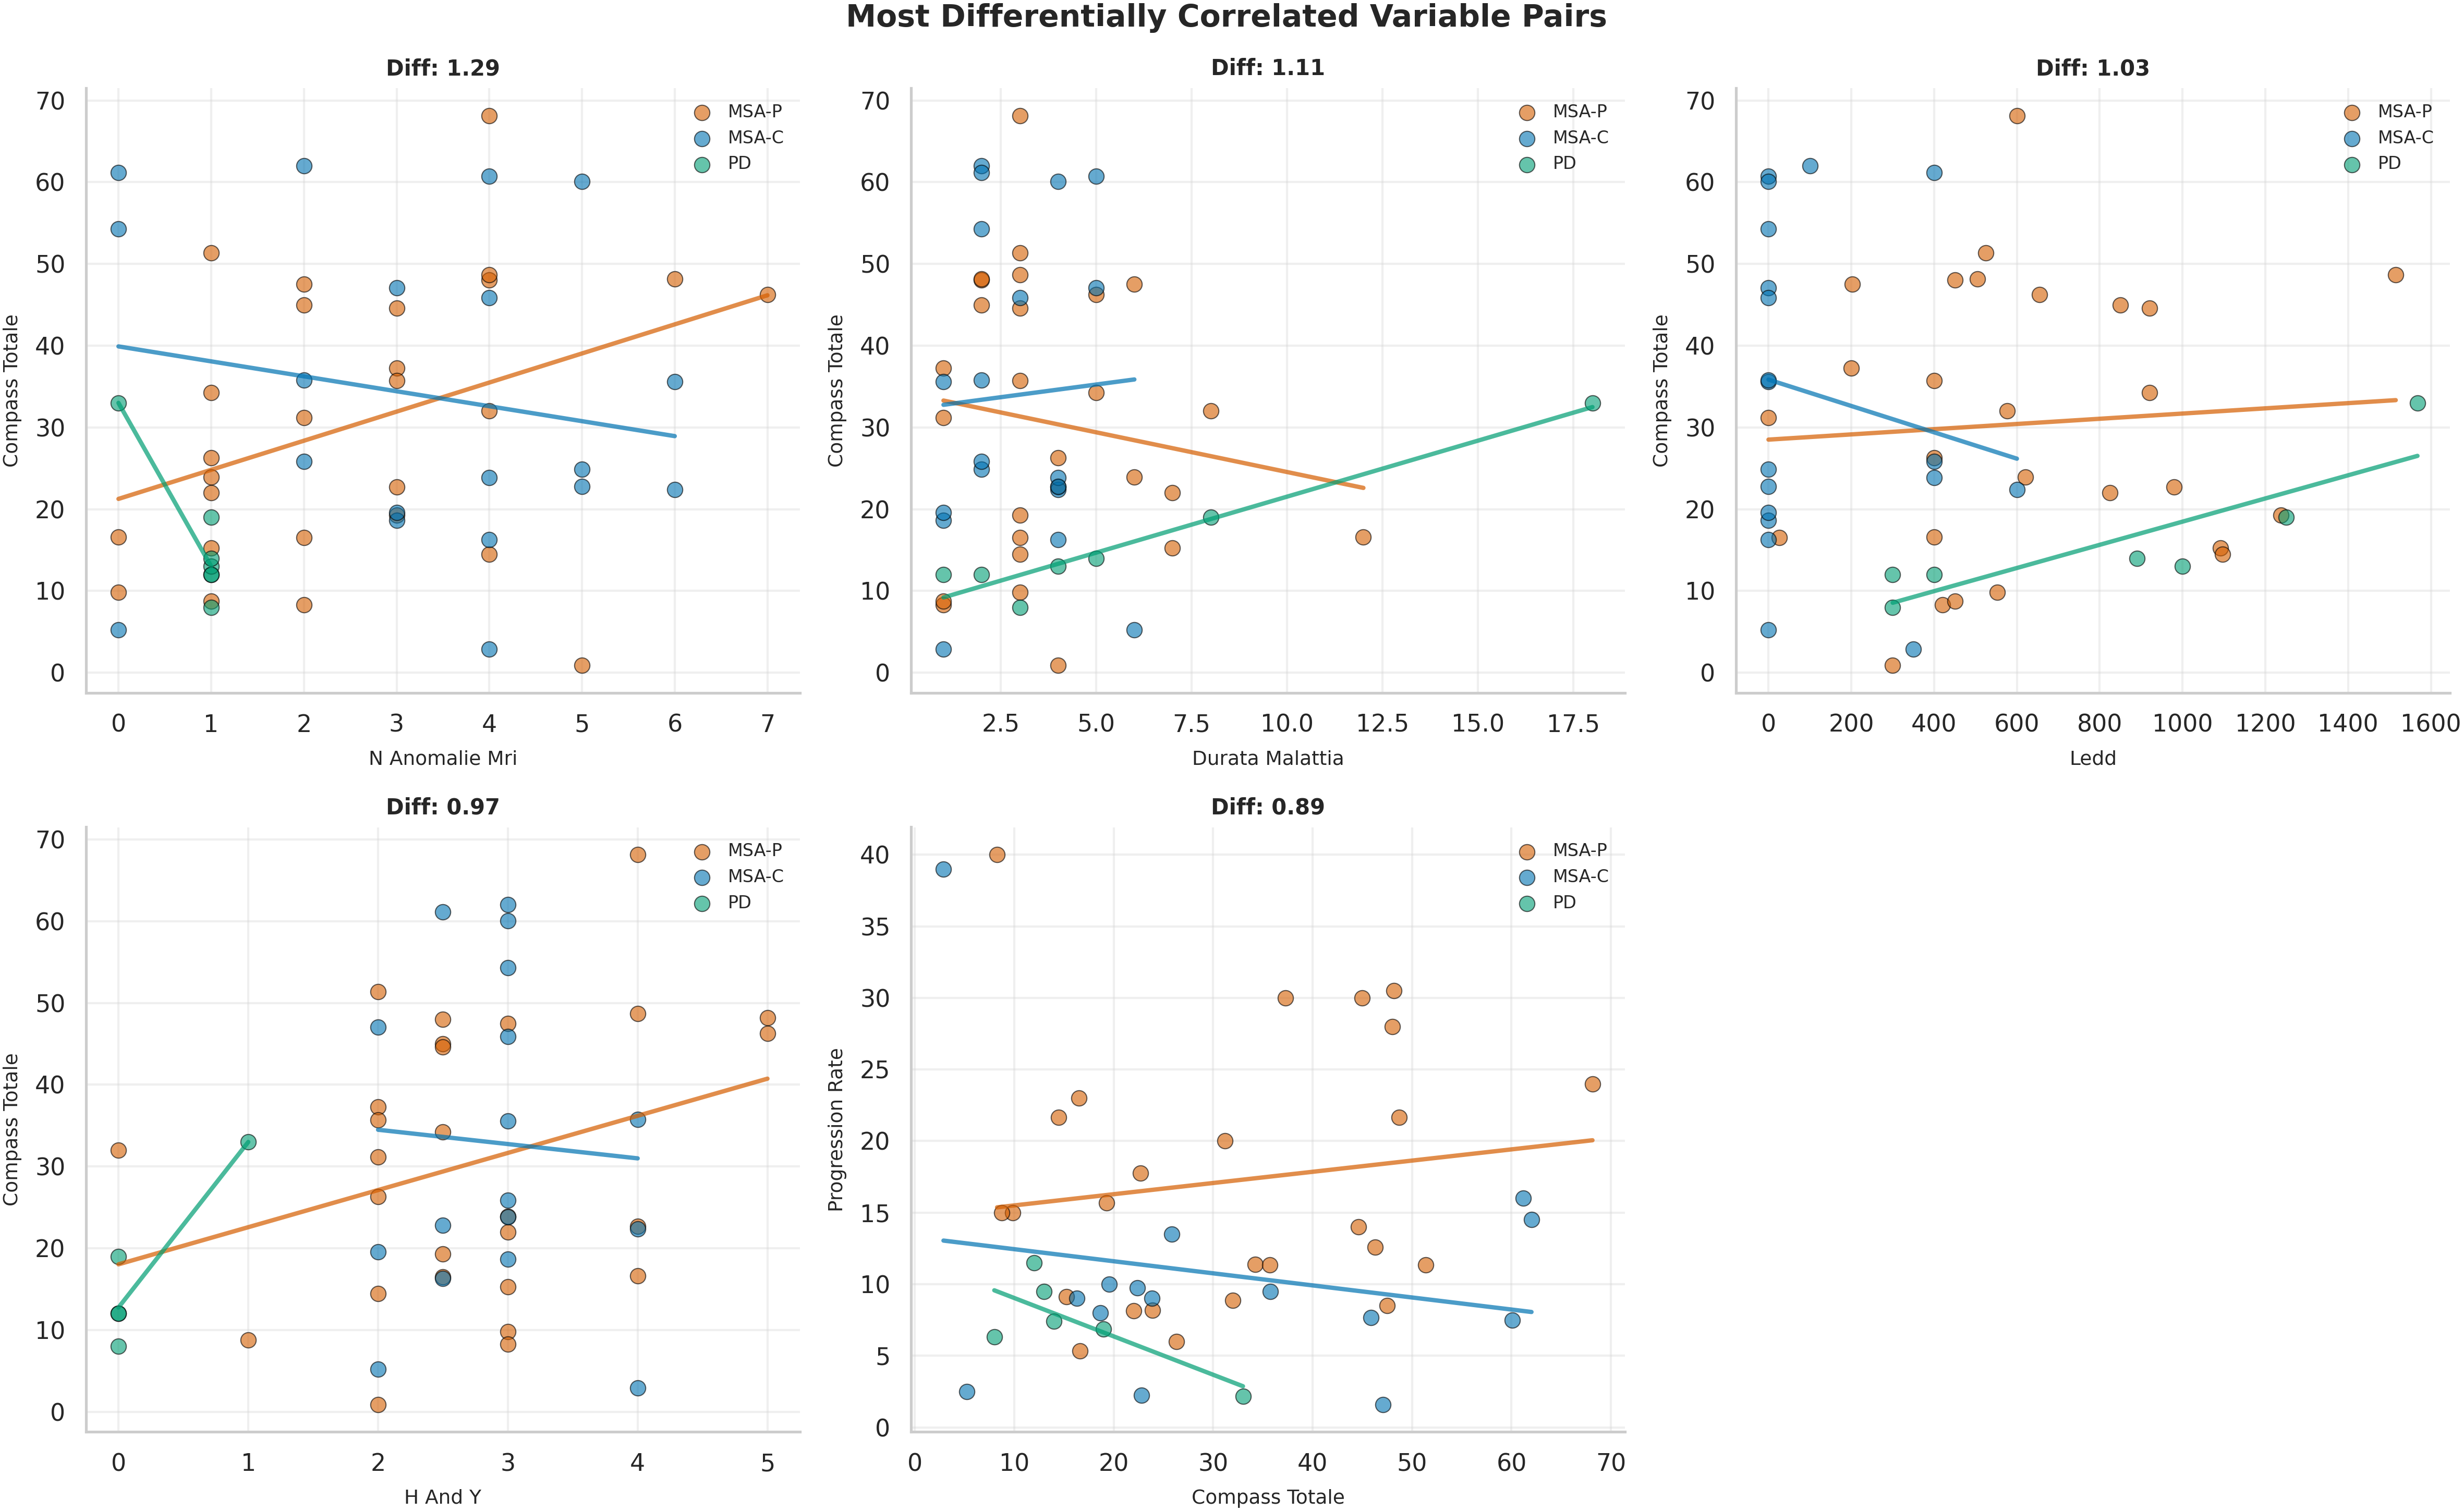

In [132]:
# Identify which correlations differ most between diagnoses
print("\n" + "=" * 70)
print("DIFFERENTIAL CORRELATIONS: Key differences between diagnoses")
print("=" * 70)

# Calculate correlations for each diagnosis
corr_msa_p = df[df['diagnosi_definita'] == 'MSA-P'][key_vars].corr()
corr_msa_c = df[df['diagnosi_definita'] == 'MSA-C'][key_vars].corr()
corr_pd = df[df['diagnosi_definita'] == 'PD'][key_vars].corr()

# Find pairs with largest differences
differences = []
for i in range(len(key_vars)):
    for j in range(i+1, len(key_vars)):
        var1, var2 = key_vars[i], key_vars[j]
        
        r_msa_p = corr_msa_p.loc[var1, var2]
        r_msa_c = corr_msa_c.loc[var1, var2]
        r_pd = corr_pd.loc[var1, var2]
        
        # Calculate max difference
        max_diff = max(abs(r_msa_p - r_pd), 
                      abs(r_msa_c - r_pd),
                      abs(r_msa_p - r_msa_c))
        
        differences.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'MSA-P': r_msa_p,
            'MSA-C': r_msa_c,
            'PD': r_pd,
            'Max Difference': max_diff
        })

# Sort by max difference and show top 10
diff_df = pd.DataFrame(differences).sort_values('Max Difference', ascending=False)
print("\n📊 Top 10 variable pairs with most different correlations:\n")
print(diff_df.head(10).to_string(index=False))

# Visualize the most differential correlations
top_pairs = diff_df.head(5)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(top_pairs.iterrows()):
    if idx >= 6:
        break
    
    ax = axes[idx]
    var1, var2 = row['Variable 1'], row['Variable 2']
    
    # Scatter plot for each diagnosis
    for diag, color in zip(['MSA-P', 'MSA-C', 'PD'], 
                          [colors_dict['MSA-P'], colors_dict['MSA-C'], colors_dict['PD']]):
        subset = df[df['diagnosi_definita'] == diag]
        x = subset[var1].dropna()
        y = subset[var2].dropna()
        
        # Get common indices
        common_idx = x.index.intersection(y.index)
        x = x.loc[common_idx]
        y = y.loc[common_idx]
        
        ax.scatter(x, y, alpha=0.6, s=50, color=color, 
                  edgecolors='black', linewidth=0.5, label=diag)
        
        # Add trend line
        if len(x) > 2:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(sorted(x), p(sorted(x)), color=color, linewidth=2, alpha=0.7)
    
    ax.set_xlabel(var1.replace('_', ' ').title(), fontsize=9)
    ax.set_ylabel(var2.replace('_', ' ').title(), fontsize=9)
    ax.set_title(f'Diff: {row["Max Difference"]:.2f}', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.3)

# Remove empty subplots
for idx in range(len(top_pairs), 6):
    axes[idx].remove()

fig.suptitle('Most Differentially Correlated Variable Pairs', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
sm.savefig(f'{IMAGES_SAVE_PATH}/differential_correlations.png')
print(f"\n✅ Saved: {IMAGES_SAVE_PATH}/differential_correlations.png")
display(Image(f'{IMAGES_SAVE_PATH}/differential_correlations.png'))